## Treball Final 

Primerament, carguem les llibreries necessaries:

In [1]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import cv2
import numpy as np
import glob
import PIL
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.models import Sequential
import sys
import random
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow

#### 1. Càrrega i pre-processament de les dades 

Primer carreguem les imatges i les pre-processem. 

In [2]:
path="D:/UNIVERSIDAD/clases/UNIVERSIDAD/3r curs/3r curs/2n semestre/aprenentatge automatic 2/images_train"

cv_img=[]

for img in glob.glob("D:/UNIVERSIDAD/clases/UNIVERSIDAD/3r curs/3r curs/2n semestre/aprenentatge automatic 2/images_train/*.png"):
    cv_img.append(cv2.imread(img))

In [3]:
def preprocess(images):
    # np array convert
    images_train=np.array(images)
    # escollim només un dels canals, per tenir les imatges en un sol color
    images_train= images_train[:,:,:,0]
    # reshape for tensorflow
    images_train=images_train.reshape(10000,128,128,1)
    # normalitzacio de les dades
    images_train = images_train.astype('float32') / 255
    return(images_train)


images_train=preprocess(cv_img)

A continuació, carreguem les etiquetes i les pre-processem: 

In [4]:
# carreguem les etiqutes
labels_train=pd.read_csv("D:/UNIVERSIDAD/clases/UNIVERSIDAD/3r curs/3r curs/2n semestre/aprenentatge automatic 2/images_train.csv")
labels_train=np.array(labels_train["lletra"])


def preprocess_labels(labels):
    # convert character to numeric
    labels_train2 =  np.unique(labels, return_inverse=True) #np unique returns the sorted unique values
    # get numerical values
    labels_train_bones=labels_train2[1]
    return(labels_train2[1])

labels_train_bones= preprocess_labels(labels_train)

Observem forma final de les imatges i de les etiquetes: 

In [5]:
print("CONJUNT DADES")
print("Dimensions del conjunt de dades d'entrenament: {}".format(images_train.shape))
print("Dimensions del conjunt d'etiquetes d'entrenament: {}".format(labels_train_bones.shape))


CONJUNT DADES
Dimensions del conjunt de dades d'entrenament: (10000, 128, 128, 1)
Dimensions del conjunt d'etiquetes d'entrenament: (10000,)


In [ ]:
#creem training and test set
# lets split data into training and test (80-20)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
 images_train, labels_train_bones, test_size=0.1)

#### Search architecture 

In [ ]:
from kerastuner.tuners import RandomSearch
import keras_tuner
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),


])

def build_model(hp):
    model=keras.Sequential([data_augmentation])
    model.add(keras.layers.AveragePooling2D(4, 3, input_shape = [128, 128,1]))
    for i in range(hp.Int("Conv Layers", min_value=1, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters",[32,64,128]),3,activation="relu"))

    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Dropout(0.5))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer2_{i}_filters",[32,64,128]),3,activation="relu"))

    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Dropout(0.5))
    

    model.add(keras.layers.Flatten())
    
    for i in range(hp.Int("Dense layers", min_value=1, max_value=4)):
        model.add(keras.layers.Dense(hp.Choice(f"Dense layer_{i}", [64, 128, 256, 512, 1024]), activation='relu'))  
        model.add(keras.layers.Dropout(0.5))


    model.add(keras.layers.Dense(52, activation='softmax'))

    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  
    return model


tuner=RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=100
    
)

tuner.search(images_train, labels_train_bones, validation_split=0.1, epochs=25, batch_size=32 )


El codi d'adalt proba diferents arquitectures i les evalua amb les condicions que tenim. No està executada. 

#### Construcció model final

Construim el model final. Incloim en el model final el data augmentation: 

In [6]:
data_augmentation = keras.Sequential([

    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),

])
model = keras.models.Sequential([
keras.layers.AveragePooling2D(4, 3, input_shape = [128, 128,1]),
keras.layers.Conv2D(128, 3, activation='relu'),
keras.layers.Conv2D(128, 3, activation='relu'),
keras.layers.Conv2D(128, 3, activation='relu'),


keras.layers.MaxPooling2D(),
keras.layers.Dropout(0.5),
keras.layers.Conv2D(128, 3, activation='relu'),
keras.layers.Conv2D(128, 3, activation='relu'),
keras.layers.Conv2D(128, 3, activation='relu'),


keras.layers.MaxPooling2D(),
keras.layers.Dropout(0.5),

keras.layers.Flatten(),
keras.layers.Dense(128, activation='relu'),

keras.layers.Dense(52, activation ='softmax')])


#optimizer = keras.optimizers.Adam(learning_rate=0.001)

model = Sequential([data_augmentation, model])
model .compile(loss = 'sparse_categorical_crossentropy',optimizer="adam", metrics = ['accuracy'])


Hem construit el model, a continuació l'entrenem: 

In [7]:
history = model.fit(images_train, labels_train_bones, epochs=200)


Epoch 1/200
313/313 [==============================] - 10s 9ms/step - loss: 3.5717 - accuracy: 0.0790
Epoch 2/200
313/313 [==============================] - 3s 8ms/step - loss: 1.9583 - accuracy: 0.4057
Epoch 3/200
313/313 [==============================] - 2s 8ms/step - loss: 1.0577 - accuracy: 0.6671
Epoch 4/200
313/313 [==============================] - 3s 8ms/step - loss: 0.6851 - accuracy: 0.7837
Epoch 5/200
313/313 [==============================] - 3s 8ms/step - loss: 0.5098 - accuracy: 0.8371
Epoch 6/200
313/313 [==============================] - 3s 8ms/step - loss: 0.4140 - accuracy: 0.8687
Epoch 7/200
313/313 [==============================] - 3s 8ms/step - loss: 0.3463 - accuracy: 0.8882
Epoch 8/200
313/313 [==============================] - 3s 8ms/step - loss: 0.3201 - accuracy: 0.8990
Epoch 9/200
313/313 [==============================] - 3s 8ms/step - loss: 0.2721 - accuracy: 0.9158
Epoch 10/200
313/313 [==============================] - 3s 8ms/step - loss: 0.2439 - accur

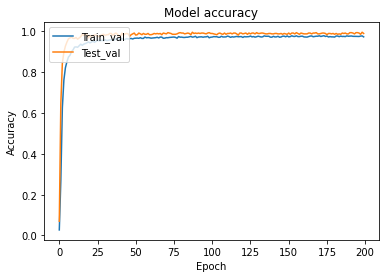

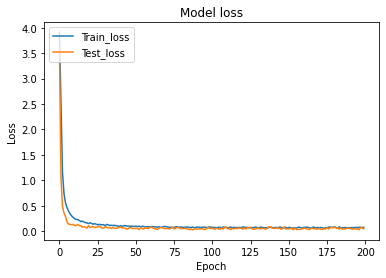

In [9]:
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train_val", "Test_val"], loc="upper left")
    plt.show()

def loss_plot(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train_loss", "Test_loss"], loc="upper left")
    plt.show()
    
    
accuracy_plot(history)
loss_plot(history)

#### K-FOLD CV


In [ ]:
# Model configuration
verbosity = 1
num_folds = 4
epochs=200
val_acc=[]
pred_model=[]
pred_reales=[]


# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = images_train
targets = labels_train_bones

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    # Define the model architecture
    data_augmentation = keras.Sequential([keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),])
    model=models.Sequential()
    model.add(keras.layers.AveragePooling2D(4, 3, input_shape = [128, 128,1]))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(52, activation ='softmax'))
    
    model = Sequential([data_augmentation, model])
    
      # Compile the model
    model .compile(loss = 'sparse_categorical_crossentropy',optimizer="adam", metrics = ['accuracy'])
    
    
      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
      # Fit data to model
    history = model.fit(inputs[train], targets[train],
                  batch_size=32,
                  epochs=epochs,
                  verbose=verbosity)
    
      # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    #we save targets and predicted values 
    p= model.predict(inputs[test])
    preds=[]
    for i in range(0, len(p)):
        preds.append(np.where(p[i]==np.amax(p[i])))
    pr=np.array(preds)
    pr=pr.tolist()
    flatten_lambda = lambda lst: (item for sublist in lst for item in sublist)
    o=list(flatten_lambda(pr))
    u=list(flatten_lambda(o)) # contiene las predicciones finales del modelo 
    
    
    
    pred_model.append(u)
    pred_reales.append(targets[test])
    
    # we save validation accuraices
    val_acc.append(scores[1])
    
      # Increase fold number
    fold_no = fold_no + 1



In [ ]:
#accuracy final
print(sum(val_acc)/len(val_acc))

#### Lletres millors classificades

No he executat ni el k-fold ja que va trigar molt de temps. Però vaig guardar-me els resultats que veuràs a continuació i que s'anomemen pred_reales i pred_model. De totes maneres, aquest codi d'avall serveix per extreure les prediccions realitzades durant el K-FOLD CV 

In [ ]:
pr=np.array(pred_reales)
pr=pr.tolist()
flatten_lambda = lambda lst: (item for sublist in lst for item in sublist)
o=list(flatten_lambda(pr))
pred_reales=o

u=list(flatten_lambda(pred_model))
pred_model=u

In [54]:

pred_reales=[37, 23, 10, 28, 37, 32, 8, 35, 12, 34, 29, 29, 14, 36, 19, 31, 15, 50, 24, 49, 15, 13, 32, 45, 13, 51, 30, 16, 2, 33, 24, 21, 8, 8, 13, 25, 21, 3, 44, 42, 49, 29, 17, 18, 31, 17, 12, 6, 38, 35, 13, 39, 45, 43, 51, 44, 18, 4, 14, 9, 24, 44, 26, 9, 17, 34, 0, 26, 20, 16, 8, 13, 25, 42, 21, 14, 4, 27, 41, 49, 14, 30, 20, 25, 35, 31, 33, 22, 9, 42, 29, 5, 30, 35, 0, 15, 28, 12, 26, 13, 4, 44, 30, 26, 26, 39, 45, 45, 29, 30, 43, 9, 0, 4, 27, 1, 41, 1, 10, 5, 8, 26, 42, 35, 26, 42, 44, 33, 3, 45, 10, 29, 49, 46, 45, 7, 19, 30, 28, 37, 26, 40, 48, 5, 28, 41, 42, 17, 20, 50, 50, 35, 0, 11, 21, 37, 19, 26, 48, 42, 41, 46, 41, 39, 44, 9, 1, 31, 1, 34, 20, 31, 35, 5, 19, 13, 42, 44, 22, 42, 24, 21, 45, 25, 47, 31, 51, 12, 19, 35, 10, 12, 28, 39, 20, 30, 36, 39, 39, 15, 23, 22, 22, 29, 22, 21, 43, 15, 15, 38, 32, 21, 6, 33, 30, 28, 21, 24, 10, 17, 37, 41, 21, 26, 33, 3, 29, 36, 50, 19, 6, 30, 23, 19, 29, 30, 40, 36, 38, 25, 25, 45, 10, 5, 17, 44, 17, 9, 13, 32, 38, 4, 28, 14, 44, 5, 29, 33, 27, 13, 43, 43, 17, 49, 25, 3, 1, 48, 2, 15, 30, 5, 51, 44, 39, 50, 17, 41, 24, 1, 6, 39, 1, 36, 47, 30, 31, 11, 1, 18, 36, 23, 2, 20, 38, 12, 9, 22, 36, 40, 20, 40, 24, 2, 25, 19, 13, 12, 6, 32, 47, 30, 12, 5, 5, 24, 36, 21, 36, 36, 51, 49, 49, 18, 8, 22, 4, 19, 5, 24, 5, 4, 10, 5, 43, 49, 25, 28, 45, 4, 43, 4, 33, 35, 19, 31, 27, 45, 47, 12, 12, 16, 38, 1, 37, 13, 26, 38, 23, 45, 5, 11, 26, 8, 43, 13, 48, 19, 22, 42, 14, 37, 33, 25, 50, 6, 34, 36, 24, 40, 15, 11, 35, 6, 3, 47, 32, 34, 47, 6, 3, 33, 45, 2, 7, 47, 22, 29, 7, 26, 45, 27, 26, 45, 42, 11, 4, 17, 35, 13, 34, 49, 15, 11, 17, 28, 40, 5, 21, 5, 0, 27, 17, 11, 27, 13, 28, 51, 32, 10, 1, 4, 47, 12, 31, 9, 33, 44, 42, 5, 44, 40, 50, 44, 27, 46, 45, 14, 12, 15, 29, 41, 44, 8, 42, 29, 24, 9, 14, 0, 26, 50, 38, 17, 47, 25, 8, 30, 35, 31, 11, 11, 33, 40, 28, 5, 15, 2, 38, 37, 34, 28, 15, 9, 44, 41, 14, 44, 25, 36, 47, 34, 32, 29, 21, 11, 49, 42, 16, 13, 26, 43, 39, 29, 13, 21, 47, 41, 32, 10, 25, 35, 27, 26, 32, 28, 33, 29, 42, 16, 40, 12, 38, 13, 44, 49, 1, 3, 2, 28, 10, 21, 49, 24, 11, 28, 4, 33, 28, 36, 25, 45, 10, 30, 15, 42, 23, 34, 5, 28, 40, 17, 29, 33, 44, 4, 36, 39, 38, 18, 28, 41, 42, 40, 12, 3, 35, 4, 20, 21, 39, 28, 42, 18, 39, 21, 33, 37, 32, 44, 44, 1, 6, 38, 21, 12, 7, 15, 40, 46, 4, 33, 0, 3, 51, 2, 17, 37, 39, 32, 31, 30, 21, 40, 12, 10, 0, 31, 6, 32, 24, 45, 13, 28, 19, 21, 11, 15, 47, 42, 16, 31, 38, 18, 38, 32, 0, 32, 8, 13, 5, 49, 33, 28, 5, 11, 27, 24, 6, 39, 40, 0, 50, 30, 25, 51, 48, 10, 15, 29, 8, 1, 35, 32, 47, 41, 2, 28, 34, 46, 17, 4, 28, 21, 24, 37, 30, 4, 35, 4, 33, 30, 44, 19, 49, 6, 20, 13, 7, 26, 41, 11, 49, 17, 24, 13, 43, 8, 23, 7, 22, 0, 7, 47, 44, 17, 49, 11, 21, 16, 45, 20, 12, 7, 0, 33, 45, 22, 51, 8, 43, 35, 32, 14, 25, 31, 11, 38, 44, 45, 51, 31, 8, 50, 17, 17, 45, 27, 12, 37, 18, 11, 15, 48, 23, 47, 47, 4, 28, 42, 37, 16, 49, 29, 51, 32, 9, 33, 42, 13, 31, 26, 26, 50, 46, 24, 44, 45, 46, 15, 21, 42, 14, 43, 51, 35, 22, 33, 48, 21, 36, 25, 37, 8, 22, 38, 9, 7, 12, 39, 7, 11, 6, 46, 0, 33, 27, 7, 20, 45, 38, 16, 41, 18, 0, 36, 35, 19, 45, 45, 7, 48, 20, 8, 32, 13, 37, 2, 6, 42, 25, 31, 49, 15, 32, 41, 31, 41, 51, 26, 3, 4, 10, 15, 6, 34, 20, 2, 21, 46, 10, 40, 9, 35, 12, 40, 20, 9, 43, 8, 30, 17, 13, 44, 50, 36, 14, 49, 26, 31, 17, 24, 1, 24, 26, 22, 29, 49, 16, 20, 28, 35, 48, 7, 6, 12, 24, 9, 26, 33, 45, 13, 47, 1, 41, 14, 19, 29, 35, 43, 41, 5, 11, 44, 7, 13, 4, 15, 17, 31, 15, 18, 36, 0, 21, 29, 5, 33, 51, 10, 47, 4, 37, 39, 13, 26, 9, 22, 5, 15, 18, 39, 24, 32, 18, 48, 30, 12, 44, 46, 0, 20, 32, 10, 39, 47, 49, 7, 40, 24, 18, 17, 21, 14, 39, 3, 31, 35, 38, 13, 32, 8, 39, 35, 41, 2, 34, 41, 22, 5, 21, 21, 36, 16, 24, 35, 6, 43, 42, 26, 20, 29, 17, 33, 23, 2, 12, 24, 0, 20, 45, 43, 21, 9, 7, 25, 25, 25, 14, 47, 38, 31, 14, 43, 49, 38, 38, 22, 16, 7, 33, 2, 7, 16, 18, 32, 11, 12, 32, 27, 5, 24, 40, 7, 24, 18, 28, 21, 49, 49, 25, 46, 46, 50, 36, 2, 38, 51, 14, 43, 47, 36, 5, 3, 8, 11, 25, 3, 48, 9, 12, 43, 4, 27, 1, 45, 22, 7, 33, 49, 27, 16, 31, 2, 38, 14, 15, 47, 15, 31, 15, 37, 21, 15, 24, 2, 26, 33, 36, 46, 34, 48, 11, 20, 46, 10, 51, 18, 21, 10, 26, 8, 38, 43, 40, 10, 8, 14, 16, 21, 32, 24, 12, 38, 9, 50, 31, 0, 27, 46, 12, 44, 4, 41, 40, 32, 49, 32, 34, 17, 15, 3, 40, 26, 5, 47, 4, 2, 48, 23, 43, 17, 8, 20, 45, 36, 37, 26, 18, 22, 51, 42, 23, 23, 13, 23, 39, 11, 44, 2, 24, 41, 34, 0, 15, 20, 27, 38, 8, 13, 28, 10, 43, 46, 28, 24, 23, 12, 14, 3, 9, 40, 9, 21, 36, 25, 41, 25, 1, 44, 36, 10, 25, 51, 20, 8, 3, 8, 35, 36, 24, 45, 6, 13, 14, 34, 18, 18, 22, 50, 10, 21, 8, 26, 5, 42, 40, 26, 48, 24, 35, 41, 45, 42, 9, 20, 35, 21, 28, 38, 45, 24, 0, 21, 48, 25, 10, 14, 51, 7, 49, 16, 36, 9, 46, 50, 26, 20, 13, 8, 49, 25, 9, 25, 30, 38, 50, 19, 1, 4, 2, 50, 21, 0, 7, 2, 42, 31, 50, 18, 25, 47, 32, 15, 51, 23, 48, 20, 17, 26, 47, 33, 24, 29, 17, 14, 33, 46, 29, 36, 34, 6, 29, 42, 5, 0, 39, 40, 8, 24, 22, 19, 29, 28, 5, 48, 31, 11, 24, 27, 4, 20, 24, 28, 38, 7, 28, 28, 19, 7, 34, 27, 21, 37, 20, 24, 29, 50, 25, 12, 41, 2, 0, 15, 25, 12, 15, 50, 6, 43, 23, 2, 29, 1, 29, 32, 36, 0, 7, 47, 14, 38, 37, 12, 36, 19, 10, 41, 8, 33, 37, 24, 4, 19, 50, 28, 15, 21, 43, 48, 12, 2, 3, 19, 9, 40, 49, 0, 15, 49, 39, 28, 24, 15, 50, 19, 33, 36, 48, 12, 38, 28, 50, 16, 26, 28, 13, 47, 0, 31, 25, 19, 0, 9, 38, 2, 31, 45, 3, 41, 4, 22, 45, 46, 24, 34, 20, 25, 22, 24, 1, 13, 48, 27, 6, 10, 27, 28, 38, 47, 42, 20, 18, 15, 23, 25, 34, 24, 35, 10, 17, 29, 47, 15, 7, 37, 13, 31, 46, 38, 46, 9, 24, 11, 46, 17, 19, 31, 44, 48, 32, 26, 30, 27, 20, 24, 40, 41, 48, 49, 34, 36, 51, 5, 23, 42, 25, 36, 42, 36, 26, 23, 31, 15, 32, 26, 9, 16, 12, 29, 46, 51, 21, 33, 9, 40, 49, 47, 32, 15, 47, 40, 22, 18, 48, 40, 26, 40, 44, 51, 30, 40, 23, 28, 45, 40, 7, 0, 46, 25, 11, 22, 14, 16, 24, 8, 35, 25, 0, 43, 41, 11, 38, 20, 48, 23, 17, 31, 30, 42, 31, 10, 33, 8, 39, 4, 40, 4, 16, 27, 42, 34, 11, 41, 1, 23, 35, 50, 38, 33, 27, 12, 44, 12, 11, 5, 18, 30, 6, 9, 27, 35, 13, 34, 4, 31, 29, 12, 43, 11, 49, 29, 24, 47, 49, 11, 51, 48, 10, 34, 23, 8, 16, 15, 50, 17, 10, 3, 29, 18, 0, 47, 45, 7, 13, 6, 18, 51, 20, 2, 42, 3, 39, 16, 36, 41, 42, 26, 27, 6, 16, 38, 3, 12, 2, 2, 29, 45, 19, 10, 48, 7, 26, 5, 20, 37, 15, 44, 45, 39, 14, 24, 23, 28, 12, 46, 4, 10, 45, 20, 1, 51, 14, 13, 38, 20, 29, 28, 49, 22, 26, 28, 40, 12, 12, 4, 12, 22, 9, 50, 23, 4, 38, 15, 17, 45, 41, 0, 50, 40, 15, 11, 6, 46, 48, 19, 50, 48, 6, 38, 40, 13, 32, 45, 25, 5, 51, 48, 34, 0, 32, 2, 10, 50, 24, 48, 35, 24, 17, 7, 35, 18, 33, 30, 17, 34, 50, 16, 25, 18, 29, 13, 6, 13, 45, 24, 48, 5, 16, 20, 19, 49, 28, 29, 31, 38, 36, 51, 4, 23, 13, 17, 5, 9, 12, 0, 12, 15, 15, 41, 14, 44, 22, 16, 27, 14, 12, 39, 49, 21, 45, 1, 39, 39, 44, 50, 25, 12, 17, 19, 13, 44, 8, 14, 41, 47, 4, 29, 33, 7, 26, 5, 12, 36, 51, 31, 31, 18, 9, 50, 47, 30, 35, 16, 9, 40, 35, 37, 1, 38, 51, 43, 39, 46, 36, 8, 24, 49, 49, 19, 31, 0, 47, 33, 19, 21, 27, 14, 40, 33, 7, 41, 47, 15, 21, 18, 6, 17, 28, 39, 51, 13, 48, 17, 40, 45, 15, 6, 48, 32, 3, 33, 38, 49, 47, 20, 25, 9, 15, 40, 10, 12, 31, 43, 1, 5, 39, 45, 10, 8, 21, 49, 7, 15, 17, 31, 1, 33, 20, 7, 22, 8, 51, 6, 43, 46, 37, 25, 4, 13, 30, 35, 35, 10, 37, 33, 42, 49, 48, 7, 11, 18, 43, 38, 11, 16, 47, 36, 38, 21, 29, 40, 10, 10, 16, 28, 29, 45, 11, 5, 29, 1, 28, 4, 4, 9, 21, 38, 30, 22, 51, 0, 30, 21, 9, 12, 32, 47, 36, 33, 16, 1, 44, 20, 6, 49, 30, 34, 15, 43, 47, 40, 10, 42, 41, 45, 13, 49, 9, 5, 48, 17, 3, 24, 13, 30, 51, 29, 22, 48, 2, 48, 8, 29, 34, 35, 13, 33, 1, 51, 40, 8, 39, 44, 9, 16, 10, 15, 43, 18, 15, 13, 48, 32, 3, 29, 46, 36, 21, 9, 18, 19, 47, 46, 32, 39, 4, 31, 12, 18, 14, 28, 42, 8, 19, 33, 50, 28, 14, 42, 2, 47, 12, 39, 39, 21, 7, 32, 9, 7, 0, 37, 36, 23, 30, 47, 16, 41, 43, 25, 15, 45, 12, 34, 21, 1, 41, 24, 37, 32, 50, 19, 45, 35, 26, 2, 2, 2, 29, 27, 3, 33, 29, 35, 48, 19, 33, 30, 41, 27, 19, 34, 29, 1, 33, 49, 44, 30, 16, 24, 28, 1, 26, 10, 11, 12, 46, 20, 11, 32, 13, 15, 0, 12, 28, 45, 40, 15, 10, 37, 5, 0, 15, 0, 40, 8, 40, 36, 4, 38, 0, 2, 10, 47, 48, 11, 32, 31, 46, 17, 4, 44, 6, 9, 14, 15, 6, 46, 46, 28, 37, 0, 10, 43, 12, 17, 20, 18, 30, 26, 48, 4, 47, 37, 28, 19, 42, 17, 24, 38, 26, 5, 3, 40, 10, 48, 48, 23, 25, 35, 33, 4, 21, 37, 15, 35, 8, 8, 23, 18, 17, 49, 48, 22, 5, 30, 4, 27, 22, 29, 1, 17, 44, 12, 48, 15, 14, 33, 0, 19, 25, 34, 7, 6, 44, 22, 17, 36, 40, 14, 28, 40, 48, 49, 26, 8, 36, 4, 15, 37, 13, 37, 41, 40, 37, 51, 25, 22, 0, 28, 21, 32, 48, 31, 35, 48, 30, 19, 29, 3, 44, 29, 44, 48, 29, 25, 24, 37, 41, 7, 29, 27, 50, 10, 9, 4, 37, 16, 11, 14, 45, 45, 27, 32, 26, 12, 16, 11, 16, 30, 2, 17, 37, 15, 36, 3, 16, 26, 13, 42, 0, 48, 41, 51, 0, 16, 37, 35, 11, 47, 43, 19, 30, 6, 19, 18, 13, 29, 3, 48, 27, 10, 32, 36, 5, 0, 4, 16, 5, 47, 30, 41, 27, 23, 5, 44, 13, 49, 26, 2, 21, 17, 39, 46, 26, 31, 29, 3, 10, 36, 12, 39, 46, 35, 26, 18, 50, 48, 0, 21, 3, 18, 25, 13, 31, 33, 10, 23, 44, 33, 49, 49, 7, 32, 44, 19, 22, 18, 33, 46, 1, 27, 24, 32, 28, 26, 25, 39, 51, 48, 33, 39, 47, 26, 19, 32, 32, 28, 41, 21, 16, 18, 27, 29, 9, 21, 18, 18, 9, 26, 31, 24, 12, 11, 34, 46, 14, 19, 22, 39, 38, 4, 40, 28, 44, 32, 31, 35, 31, 42, 46, 23, 1, 5, 50, 42, 22, 40, 1, 26, 6, 14, 44, 20, 8, 8, 30, 13, 43, 43, 28, 28, 13, 44, 19, 23, 43, 2, 45, 6, 44, 49, 25, 51, 4, 38, 9, 11, 23, 44, 20, 2, 34, 24, 34, 34, 50, 28, 7, 40, 41, 19, 43, 7, 7, 47, 2, 12, 33, 7, 6, 20, 18, 44, 51, 35, 10, 31, 7, 44, 40, 30, 23, 35, 36, 11, 15, 6, 2, 39, 10, 44, 29, 32, 40, 30, 21, 4, 23, 8, 29, 44, 23, 7, 43, 28, 19, 11, 41, 12, 6, 42, 25, 11, 6, 15, 39, 7, 3, 43, 38, 9, 48, 33, 15, 11, 14, 24, 45, 5, 40, 23, 10, 24, 36, 25, 5, 46, 48, 29, 5, 39, 35, 28, 29, 37, 46, 24, 32, 33, 22, 45, 42, 18, 10, 4, 4, 14, 5, 27, 50, 49, 16, 20, 49, 43, 11, 11, 31, 20, 41, 40, 48, 3, 24, 14, 49, 8, 37, 14, 42, 27, 23, 32, 9, 12, 42, 9, 38, 49, 38, 27, 43, 20, 43, 4, 43, 26, 17, 42, 33, 12, 9, 40, 26, 18, 33, 45, 46, 39, 29, 8, 8, 25, 27, 44, 18, 35, 24, 50, 24, 34, 6, 8, 33, 1, 0, 20, 35, 16, 30, 34, 21, 17, 16, 3, 38, 14, 30, 44, 24, 11, 22, 43, 21, 22, 26, 2, 50, 10, 24, 7, 23, 2, 37, 27, 18, 44, 12, 2, 43, 45, 50, 35, 38, 30, 51, 45, 7, 9, 13, 46, 2, 46, 16, 38, 10, 15, 9, 25, 49, 39, 19, 50, 45, 7, 47, 35, 43, 11, 9, 1, 32, 32, 43, 32, 35, 49, 1, 15, 16, 2, 24, 44, 31, 30, 18, 15, 13, 11, 22, 32, 6, 51, 8, 46, 19, 37, 34, 17, 30, 36, 36, 28, 11, 44, 9, 1, 2, 50, 8, 4, 46, 36, 45, 43, 44, 6, 49, 2, 27, 20, 13, 28, 2, 17, 0, 50, 19, 28, 19, 32, 16, 20, 45, 46, 4, 21, 50, 17, 14, 50, 48, 17, 37, 46, 32, 26, 36, 17, 42, 21, 21, 0, 23, 18, 8, 39, 15, 36, 40, 47, 28, 49, 37, 47, 41, 13, 40, 17, 26, 23, 21, 18, 50, 9, 50, 36, 18, 8, 50, 40, 37, 38, 29, 26, 43, 33, 28, 39, 20, 47, 7, 42, 17, 13, 37, 1, 6, 40, 23, 51, 21, 38, 49, 22, 5, 10, 15, 9, 17, 23, 8, 3, 47, 0, 14, 25, 42, 18, 25, 3, 7, 24, 2, 13, 39, 35, 22, 44, 11, 40, 21, 25, 25, 30, 3, 10, 0, 14, 8, 40, 35, 46, 30, 40, 15, 31, 5, 37, 47, 49, 12, 51, 37, 25, 22, 9, 22, 5, 1, 49, 17, 19, 6, 15, 20, 24, 42, 13, 46, 44, 23, 0, 10, 49, 13, 51, 15, 39, 35, 13, 50, 1, 42, 48, 17, 40, 47, 28, 13, 12, 20, 21, 46, 26, 14, 14, 37, 9, 26, 9, 34, 35, 1, 41, 20, 21, 29, 30, 11, 41, 6, 3, 2, 16, 30, 17, 1, 16, 21, 26, 44, 16, 48, 16, 39, 25, 23, 27, 50, 31, 6, 27, 28, 47, 14, 19, 31, 24, 32, 25, 9, 7, 37, 37, 12, 27, 34, 36, 19, 19, 14, 8, 6, 19, 33, 12, 33, 27, 10, 8, 6, 31, 43, 30, 22, 21, 15, 18, 45, 12, 14, 3, 12, 40, 47, 45, 13, 24, 45, 23, 3, 34, 48, 31, 22, 2, 46, 51, 6, 20, 37, 36, 29, 45, 0, 35, 4, 17, 24, 10, 35, 51, 11, 44, 19, 1, 41, 34, 23, 8, 33, 27, 3, 22, 6, 28, 0, 29, 23, 23, 44, 0, 50, 49, 30, 15, 44, 0, 35, 28, 34, 0, 48, 9, 29, 48, 26, 15, 16, 38, 46, 42, 32, 44, 46, 31, 36, 0, 38, 41, 14, 10, 37, 49, 21, 38, 9, 18, 23, 23, 30, 1, 12, 14, 49, 41, 12, 46, 12, 38, 49, 34, 17, 47, 24, 10, 20, 39, 28, 33, 44, 11, 18, 20, 8, 14, 33, 45, 12, 44, 50, 30, 51, 39, 40, 35, 24, 22, 51, 13, 13, 49, 33, 26, 47, 37, 9, 45, 9, 17, 8, 8, 43, 41, 3, 1, 4, 1, 50, 36, 35, 13, 11, 1, 26, 24, 48, 35, 49, 36, 23, 10, 14, 28, 11, 27, 20, 13, 25, 24, 38, 37, 25, 3, 19, 37, 35, 23, 39, 8, 46, 3, 28, 3, 40, 9, 13, 25, 34, 4, 13, 5, 40, 19, 27, 34, 47, 31, 48, 32, 48, 26, 50, 40, 9, 30, 4, 17, 39, 28, 20, 20, 23, 34, 8, 13, 2, 29, 51, 50, 28, 25, 9, 20, 45, 4, 39, 8, 50, 40, 48, 34, 27, 23, 15, 51, 39, 48, 1, 21, 3, 41, 43, 3, 49, 39, 51, 0, 26, 43, 28, 0, 38, 20, 13, 15, 21, 10, 17, 13, 24, 16, 16, 35, 2, 0, 31, 47, 14, 33, 46, 24, 34, 29, 17, 7, 6, 24, 17, 29, 24, 42, 5, 14, 21, 46, 34, 19, 42, 0, 16, 19, 0, 8, 49, 32, 14, 12, 15, 27, 50, 1, 44, 50, 4, 10, 48, 46, 43, 47, 24, 51, 36, 21, 8, 51, 19, 29, 4, 33, 41, 44, 6, 5, 32, 42, 37, 41, 35, 14, 23, 24, 0, 33, 43, 30, 26, 8, 27, 39, 17, 4, 16, 46, 14, 4, 0, 38, 13, 46, 10, 5, 23, 31, 40, 11, 44, 49, 20, 4, 16, 1, 51, 50, 20, 4, 51, 0, 50, 18, 9, 38, 20, 2, 40, 21, 11, 50, 26, 9, 4, 34, 35, 51, 39, 3, 25, 21, 13, 41, 31, 22, 20, 13, 34, 34, 7, 29, 6, 42, 1, 33, 1, 4, 4, 4, 8, 9, 2, 49, 43, 41, 34, 39, 38, 21, 28, 48, 6, 32, 4, 8, 7, 2, 46, 2, 40, 14, 35, 33, 28, 50, 43, 23, 46, 15, 39, 41, 43, 32, 9, 13, 27, 0, 47, 17, 43, 1, 50, 37, 19, 19, 6, 33, 45, 47, 39, 14, 31, 43, 25, 25, 32, 41, 10, 22, 16, 5, 21, 38, 25, 22, 44, 19, 17, 47, 24, 50, 38, 20, 4, 42, 20, 41, 14, 20, 35, 10, 28, 17, 50, 36, 42, 5, 38, 21, 0, 13, 36, 42, 41, 30, 1, 16, 18, 33, 18, 37, 0, 46, 34, 32, 47, 9, 43, 28, 31, 44, 10, 46, 40, 36, 44, 47, 31, 17, 13, 1, 35, 47, 29, 36, 2, 12, 27, 35, 15, 37, 12, 9, 14, 47, 18, 45, 15, 23, 15, 45, 49, 48, 7, 22, 42, 25, 37, 45, 17, 3, 45, 41, 2, 24, 32, 2, 34, 7, 2, 28, 42, 26, 13, 11, 17, 39, 50, 4, 33, 26, 13, 35, 2, 15, 25, 34, 42, 2, 42, 10, 0, 42, 31, 6, 46, 46, 38, 22, 25, 35, 12, 42, 28, 21, 7, 7, 47, 14, 35, 11, 11, 29, 5, 0, 22, 34, 32, 31, 5, 13, 19, 29, 40, 43, 23, 19, 22, 30, 3, 23, 2, 15, 38, 2, 18, 39, 38, 27, 33, 12, 30, 18, 35, 18, 12, 5, 48, 10, 35, 36, 22, 31, 17, 47, 36, 20, 33, 35, 25, 10, 4, 43, 15, 6, 41, 21, 4, 26, 23, 26, 38, 40, 48, 3, 2, 2, 10, 38, 25, 36, 13, 3, 21, 31, 22, 48, 15, 10, 49, 6, 45, 2, 39, 1, 32, 40, 23, 29, 42, 46, 51, 4, 40, 44, 40, 20, 30, 37, 17, 4, 42, 9, 10, 11, 26, 14, 16, 25, 11, 27, 32, 50, 10, 38, 22, 34, 2, 11, 7, 13, 20, 38, 37, 15, 22, 10, 33, 41, 18, 7, 49, 30, 3, 46, 40, 20, 34, 13, 14, 26, 19, 0, 42, 48, 44, 22, 24, 51, 11, 33, 1, 50, 17, 5, 28, 9, 42, 31, 34, 50, 36, 39, 10, 4, 46, 19, 46, 16, 21, 15, 34, 40, 31, 30, 39, 42, 34, 16, 47, 25, 38, 19, 35, 4, 38, 28, 17, 24, 29, 45, 10, 23, 11, 10, 36, 8, 27, 4, 6, 26, 41, 35, 17, 15, 38, 25, 33, 12, 23, 42, 24, 14, 21, 44, 7, 48, 30, 11, 35, 8, 13, 24, 5, 1, 3, 9, 42, 12, 5, 15, 21, 44, 30, 14, 48, 31, 16, 24, 21, 16, 9, 48, 45, 6, 44, 19, 36, 14, 20, 49, 51, 2, 47, 48, 41, 2, 37, 46, 12, 5, 29, 42, 13, 39, 18, 13, 40, 28, 31, 5, 4, 26, 46, 47, 8, 17, 46, 1, 6, 28, 23, 17, 36, 30, 29, 7, 4, 21, 42, 3, 19, 43, 8, 42, 18, 9, 25, 41, 46, 9, 36, 21, 34, 9, 47, 36, 22, 30, 51, 48, 5, 31, 46, 20, 20, 6, 8, 48, 24, 45, 7, 8, 46, 43, 14, 9, 38, 30, 48, 1, 37, 37, 31, 17, 1, 37, 49, 6, 25, 35, 9, 7, 19, 27, 47, 40, 23, 32, 20, 26, 48, 7, 47, 32, 26, 2, 13, 39, 2, 21, 22, 2, 9, 23, 23, 51, 40, 22, 26, 7, 40, 31, 50, 34, 27, 39, 34, 30, 11, 50, 16, 10, 36, 23, 45, 15, 41, 26, 5, 39, 22, 21, 45, 14, 35, 13, 37, 19, 5, 44, 0, 43, 2, 39, 44, 14, 51, 20, 47, 21, 44, 39, 34, 14, 23, 25, 7, 11, 3, 16, 10, 1, 18, 36, 10, 49, 39, 24, 45, 19, 13, 40, 37, 15, 18, 28, 15, 51, 32, 14, 38, 39, 17, 38, 29, 40, 33, 24, 26, 24, 33, 21, 5, 12, 51, 32, 0, 50, 17, 23, 44, 6, 32, 22, 18, 38, 1, 40, 29, 29, 40, 17, 8, 25, 50, 31, 5, 47, 21, 10, 22, 48, 20, 33, 10, 3, 31, 40, 25, 29, 36, 40, 22, 14, 44, 16, 51, 43, 51, 47, 37, 0, 6, 11, 6, 27, 30, 1, 21, 10, 35, 47, 14, 6, 12, 21, 1, 18, 30, 41, 8, 9, 15, 35, 35, 21, 48, 11, 22, 34, 46, 42, 45, 23, 37, 11, 4, 21, 12, 46, 23, 33, 44, 14, 20, 12, 10, 33, 43, 25, 25, 40, 40, 42, 36, 1, 31, 40, 7, 48, 11, 28, 2, 38, 42, 6, 16, 48, 43, 24, 15, 30, 40, 7, 20, 16, 42, 41, 10, 26, 16, 6, 28, 28, 30, 6, 20, 14, 26, 8, 16, 5, 0, 14, 48, 39, 23, 22, 14, 20, 48, 37, 2, 29, 20, 13, 35, 2, 17, 10, 25, 5, 25, 19, 1, 33, 17, 7, 0, 10, 0, 26, 49, 11, 21, 44, 12, 38, 11, 46, 11, 8, 6, 34, 11, 20, 46, 50, 42, 39, 37, 15, 1, 1, 14, 15, 32, 19, 12, 49, 6, 18, 28, 40, 43, 15, 49, 8, 43, 34, 42, 0, 19, 8, 45, 11, 2, 32, 41, 30, 38, 13, 26, 21, 44, 48, 37, 6, 36, 20, 9, 51, 31, 10, 7, 36, 48, 22, 36, 36, 22, 30, 44, 48, 35, 1, 20, 30, 44, 12, 26, 12, 45, 13, 38, 49, 2, 3, 3, 6, 14, 38, 39, 28, 41, 42, 50, 4, 46, 21, 47, 16, 21, 19, 16, 44, 22, 3, 19, 20, 47, 15, 31, 37, 18, 26, 18, 32, 35, 6, 42, 42, 0, 20, 34, 27, 17, 12, 30, 48, 0, 14, 3, 30, 34, 26, 40, 20, 26, 1, 32, 17, 8, 35, 40, 47, 44, 48, 21, 43, 24, 3, 39, 12, 47, 47, 37, 22, 31, 42, 34, 28, 14, 26, 32, 35, 0, 4, 45, 9, 45, 46, 48, 38, 47, 10, 5, 42, 27, 51, 28, 24, 35, 27, 17, 1, 39, 20, 30, 30, 34, 18, 14, 37, 42, 32, 34, 7, 48, 11, 2, 10, 24, 41, 16, 35, 8, 16, 2, 44, 17, 43, 18, 18, 7, 31, 17, 26, 35, 1, 11, 7, 7, 46, 47, 14, 29, 50, 33, 14, 45, 28, 10, 24, 35, 50, 10, 33, 40, 42, 46, 45, 35, 36, 47, 39, 24, 23, 19, 50, 14, 24, 5, 17, 22, 40, 35, 18, 12, 27, 36, 21, 5, 48, 22, 29, 49, 37, 50, 27, 41, 51, 16, 44, 31, 32, 11, 36, 37, 6, 51, 2, 11, 30, 35, 26, 2, 10, 5, 15, 21, 2, 32, 47, 45, 13, 39, 49, 39, 18, 9, 1, 46, 41, 34, 44, 32, 37, 29, 15, 33, 17, 27, 23, 30, 15, 48, 7, 41, 26, 3, 42, 20, 46, 24, 24, 18, 48, 1, 10, 43, 11, 49, 44, 24, 26, 12, 30, 48, 24, 35, 9, 51, 41, 38, 0, 36, 48, 6, 2, 5, 17, 45, 33, 50, 42, 10, 15, 4, 23, 46, 48, 32, 35, 31, 44, 38, 7, 25, 48, 10, 29, 32, 49, 45, 7, 43, 4, 35, 23, 5, 44, 50, 24, 28, 43, 48, 33, 8, 47, 13, 38, 41, 45, 46, 19, 46, 16, 1, 3, 11, 24, 48, 28, 47, 11, 1, 45, 51, 24, 49, 43, 4, 41, 42, 43, 29, 13, 22, 39, 11, 18, 20, 41, 23, 0, 49, 3, 29, 31, 38, 32, 46, 8, 50, 1, 37, 5, 13, 40, 48, 51, 4, 21, 4, 37, 10, 7, 10, 26, 33, 45, 1, 18, 47, 18, 3, 20, 39, 23, 18, 11, 13, 3, 28, 39, 46, 20, 26, 16, 47, 37, 7, 3, 47, 32, 9, 36, 27, 47, 14, 41, 15, 33, 20, 41, 11, 13, 35, 46, 35, 48, 40, 21, 0, 25, 27, 11, 19, 4, 9, 47, 23, 18, 49, 6, 14, 18, 25, 15, 30, 17, 31, 12, 25, 11, 50, 25, 1, 34, 41, 17, 50, 33, 42, 23, 29, 43, 24, 31, 49, 34, 27, 38, 50, 22, 6, 33, 43, 8, 5, 10, 3, 7, 8, 12, 8, 4, 35, 19, 0, 27, 20, 35, 12, 2, 16, 23, 35, 43, 48, 10, 28, 46, 46, 20, 12, 3, 43, 16, 35, 14, 24, 14, 39, 1, 44, 47, 21, 26, 35, 34, 39, 21, 46, 3, 21, 23, 9, 40, 31, 9, 8, 2, 26, 7, 50, 5, 11, 43, 10, 0, 46, 28, 23, 47, 6, 39, 26, 2, 32, 31, 13, 42, 2, 33, 23, 47, 38, 17, 26, 12, 44, 13, 7, 23, 40, 43, 34, 48, 15, 17, 39, 30, 45, 30, 8, 20, 14, 27, 7, 2, 24, 9, 21, 27, 6, 26, 3, 36, 49, 26, 6, 30, 9, 20, 49, 39, 39, 12, 7, 25, 42, 36, 35, 9, 44, 50, 41, 16, 30, 4, 30, 29, 12, 14, 22, 46, 29, 23, 14, 10, 25, 19, 22, 33, 5, 27, 24, 19, 27, 5, 22, 1, 18, 50, 11, 1, 37, 42, 6, 37, 4, 27, 34, 26, 36, 1, 50, 10, 8, 51, 20, 11, 6, 39, 33, 33, 40, 50, 7, 6, 7, 46, 46, 7, 19, 47, 12, 8, 2, 38, 46, 29, 5, 45, 21, 19, 19, 38, 6, 14, 48, 22, 45, 1, 8, 47, 10, 48, 15, 49, 21, 37, 48, 46, 21, 26, 29, 6, 9, 0, 19, 20, 48, 29, 36, 23, 21, 13, 37, 36, 36, 12, 8, 5, 2, 43, 48, 35, 44, 2, 18, 41, 11, 29, 35, 3, 28, 22, 43, 40, 9, 46, 17, 14, 5, 16, 19, 11, 38, 23, 16, 6, 42, 35, 30, 14, 17, 19, 8, 37, 43, 36, 1, 19, 49, 31, 32, 34, 13, 19, 33, 0, 50, 14, 12, 25, 44, 13, 51, 47, 19, 11, 36, 8, 47, 22, 19, 40, 39, 23, 25, 12, 12, 6, 28, 1, 42, 45, 38, 36, 35, 42, 22, 23, 32, 6, 2, 27, 48, 37, 22, 24, 26, 49, 41, 39, 11, 12, 41, 8, 40, 5, 12, 14, 47, 39, 15, 23, 24, 32, 51, 5, 10, 1, 12, 47, 35, 48, 23, 38, 45, 3, 33, 34, 34, 44, 29, 40, 30, 13, 35, 48, 26, 51, 14, 1, 28, 41, 48, 46, 45, 21, 18, 7, 26, 47, 41, 17, 49, 22, 5, 45, 2, 17, 19, 46, 51, 21, 51, 29, 41, 2, 5, 12, 50, 23, 22, 12, 13, 48, 27, 42, 50, 32, 41, 39, 22, 0, 49, 50, 35, 5, 26, 4, 40, 7, 12, 13, 13, 13, 33, 26, 36, 4, 47, 10, 12, 24, 51, 40, 47, 17, 17, 51, 50, 4, 2, 44, 47, 8, 48, 43, 30, 28, 28, 49, 20, 45, 16, 10, 44, 19, 45, 45, 29, 31, 29, 19, 32, 30, 10, 2, 2, 22, 26, 26, 24, 5, 4, 26, 13, 1, 47, 5, 45, 16, 7, 24, 35, 2, 10, 25, 30, 19, 18, 18, 26, 21, 47, 26, 33, 37, 36, 35, 0, 18, 32, 38, 17, 38, 23, 40, 14, 18, 1, 51, 42, 28, 8, 8, 17, 32, 6, 32, 39, 36, 2, 42, 16, 31, 29, 35, 13, 29, 27, 8, 5, 47, 31, 9, 6, 6, 21, 27, 41, 29, 41, 38, 26, 18, 1, 51, 49, 4, 21, 5, 13, 16, 36, 38, 1, 8, 43, 3, 25, 18, 32, 11, 34, 35, 12, 15, 13, 25, 16, 25, 21, 15, 25, 42, 2, 40, 4, 31, 25, 43, 17, 9, 37, 14, 24, 40, 48, 6, 17, 9, 40, 26, 13, 28, 29, 19, 21, 12, 22, 40, 31, 35, 15, 2, 5, 21, 21, 5, 40, 46, 9, 31, 46, 49, 30, 32, 20, 15, 49, 25, 2, 2, 30, 35, 8, 0, 37, 36, 2, 16, 2, 22, 31, 29, 41, 24, 30, 41, 8, 30, 42, 27, 19, 25, 37, 31, 6, 15, 32, 21, 26, 21, 14, 42, 29, 50, 41, 5, 46, 27, 48, 24, 5, 44, 5, 1, 5, 35, 19, 15, 42, 51, 10, 10, 3, 47, 12, 15, 30, 8, 10, 6, 39, 14, 5, 38, 34, 47, 50, 8, 3, 9, 5, 36, 28, 34, 0, 32, 2, 20, 47, 40, 29, 31, 31, 0, 19, 6, 36, 30, 2, 29, 4, 12, 48, 11, 12, 34, 47, 24, 35, 27, 28, 7, 11, 33, 6, 38, 6, 19, 27, 46, 0, 35, 28, 41, 31, 7, 45, 20, 6, 13, 15, 16, 41, 35, 24, 42, 26, 24, 44, 41, 37, 39, 13, 1, 37, 22, 12, 4, 42, 48, 39, 32, 23, 25, 41, 47, 18, 42, 34, 37, 18, 37, 23, 16, 26, 0, 2, 10, 21, 18, 25, 34, 20, 6, 12, 2, 11, 20, 36, 41, 20, 23, 30, 46, 47, 4, 6, 20, 19, 18, 43, 51, 49, 29, 8, 22, 7, 41, 29, 45, 48, 32, 40, 28, 25, 49, 5, 36, 17, 23, 1, 13, 25, 0, 16, 51, 20, 35, 11, 17, 11, 5, 17, 1, 3, 36, 45, 41, 50, 27, 7, 0, 17, 9, 50, 41, 0, 48, 19, 7, 41, 46, 23, 15, 10, 1, 31, 41, 18, 32, 24, 1, 23, 24, 11, 1, 32, 37, 24, 14, 35, 33, 47, 36, 16, 35, 47, 6, 37, 44, 0, 37, 27, 31, 28, 28, 38, 13, 17, 36, 47, 0, 17, 41, 41, 27, 47, 42, 34, 13, 20, 4, 45, 28, 38, 50, 7, 1, 34, 29, 23, 37, 9, 2, 38, 27, 19, 24, 11, 30, 25, 36, 0, 12, 49, 8, 31, 46, 2, 18, 32, 39, 8, 50, 20, 7, 51, 35, 7, 43, 3, 46, 51, 32, 34, 5, 34, 51, 13, 45, 29, 11, 4, 10, 17, 36, 0, 1, 36, 20, 9, 9, 16, 16, 46, 11, 45, 33, 29, 42, 23, 4, 37, 41, 15, 38, 37, 19, 28, 38, 6, 33, 32, 39, 21, 18, 2, 26, 1, 24, 51, 15, 34, 41, 46, 34, 20, 7, 26, 8, 48, 27, 36, 47, 25, 35, 20, 6, 10, 18, 45, 19, 21, 29, 23, 29, 28, 1, 8, 5, 3, 6, 10, 37, 33, 3, 34, 10, 12, 21, 19, 16, 26, 21, 20, 25, 25, 39, 11, 29, 44, 25, 40, 14, 46, 9, 7, 21, 47, 5, 8, 16, 3, 37, 2, 48, 1, 43, 7, 5, 22, 3, 33, 35, 4, 21, 24, 2, 31, 27, 44, 12, 49, 49, 19, 17, 37, 34, 35, 50, 27, 44, 36, 16, 30, 6, 34, 30, 16, 35, 48, 8, 31, 30, 0, 9, 41, 33, 28, 38, 10, 32, 47, 29, 23, 33, 12, 13, 31, 4, 39, 50, 16, 6, 47, 3, 48, 5, 19, 9, 5, 46, 50, 11, 43, 45, 0, 31, 4, 46, 29, 47, 0, 13, 20, 24, 19, 7, 36, 21, 39, 12, 17, 13, 30, 6, 8, 3, 9, 33, 46, 29, 6, 47, 18, 11, 27, 39, 28, 36, 0, 42, 7, 34, 16, 25, 47, 38, 36, 28, 42, 12, 6, 26, 28, 15, 13, 15, 0, 7, 35, 36, 32, 18, 5, 13, 42, 37, 14, 38, 15, 27, 50, 14, 51, 43, 38, 45, 34, 14, 19, 51, 33, 40, 0, 33, 9, 25, 45, 21, 35, 4, 46, 2, 2, 43, 4, 49, 31, 7, 21, 29, 16, 18, 25, 8, 12, 49, 17, 50, 27, 6, 6, 17, 11, 24, 7, 29, 23, 44, 41, 29, 12, 11, 26, 31, 16, 17, 36, 46, 20, 24, 24, 14, 39, 14, 36, 30, 5, 46, 25, 6, 48, 42, 41, 11, 44, 42, 46, 8, 28, 21, 35, 4, 20, 15, 1, 26, 51, 25, 2, 26, 11, 44, 28, 25, 46, 15, 40, 21, 34, 13, 6, 46, 15, 17, 12, 38, 40, 46, 20, 29, 38, 25, 39, 32, 11, 40, 17, 11, 14, 49, 37, 8, 1, 37, 0, 11, 7, 7, 39, 31, 4, 20, 6, 47, 22, 33, 48, 44, 40, 41, 13, 28, 13, 2, 16, 43, 25, 22, 28, 35, 51, 7, 39, 33, 31, 7, 29, 30, 15, 3, 6, 47, 10, 36, 20, 21, 45, 15, 20, 50, 41, 10, 5, 9, 29, 7, 13, 47, 2, 2, 27, 23, 35, 26, 40, 39, 7, 35, 6, 36, 45, 50, 21, 25, 6, 42, 37, 22, 43, 14, 44, 44, 3, 18, 6, 18, 26, 34, 50, 26, 49, 10, 10, 28, 26, 32, 32, 21, 11, 50, 44, 50, 39, 33, 44, 33, 46, 29, 8, 19, 36, 0, 28, 38, 1, 20, 13, 19, 35, 33, 38, 34, 12, 30, 47, 40, 23, 7, 10, 4, 11, 48, 48, 24, 42, 50, 30, 14, 24, 35, 5, 15, 48, 26, 32, 44, 10, 30, 1, 30, 46, 35, 20, 49, 20, 8, 6, 16, 37, 26, 41, 44, 6, 46, 0, 40, 43, 31, 19, 3, 17, 7, 41, 50, 12, 25, 22, 25, 4, 29, 3, 42, 3, 6, 50, 23, 26, 3, 24, 43, 37, 11, 17, 17, 40, 39, 10, 36, 50, 40, 19, 17, 20, 12, 25, 19, 13, 33, 46, 0, 51, 50, 13, 16, 17, 26, 48, 49, 5, 9, 0, 3, 48, 38, 5, 36, 3, 38, 17, 28, 37, 23, 5, 8, 15, 17, 40, 25, 44, 5, 18, 10, 36, 24, 5, 41, 22, 15, 28, 23, 5, 37, 30, 15, 7, 26, 22, 20, 35, 34, 6, 17, 13, 31, 25, 24, 32, 19, 38, 39, 33, 4, 26, 39, 48, 43, 49, 41, 23, 51, 46, 25, 12, 21, 27, 13, 6, 38, 6, 50, 4, 1, 7, 11, 31, 37, 21, 24, 46, 23, 21, 11, 2, 4, 14, 41, 34, 12, 12, 50, 12, 23, 51, 39, 46, 7, 46, 1, 14, 13, 42, 41, 20, 39, 16, 40, 23, 18, 32, 46, 41, 26, 34, 33, 34, 3, 6, 0, 37, 26, 34, 26, 14, 48, 39, 1, 48, 28, 13, 0, 28, 39, 28, 38, 21, 28, 35, 23, 40, 36, 2, 35, 3, 31, 36, 42, 25, 41, 26, 22, 12, 16, 7, 1, 10, 2, 14, 44, 15, 33, 33, 14, 10, 39, 36, 46, 17, 47, 38, 19, 44, 12, 32, 17, 2, 7, 27, 35, 17, 48, 16, 12, 21, 28, 50, 5, 8, 3, 0, 33, 14, 3, 24, 44, 48, 37, 9, 8, 9, 34, 15, 29, 46, 42, 39, 1, 24, 8, 31, 1, 5, 29, 47, 18, 21, 2, 20, 47, 41, 41, 23, 23, 33, 31, 42, 51, 5, 47, 13, 38, 38, 51, 10, 31, 12, 0, 15, 33, 33, 3, 31, 3, 36, 3, 35, 13, 49, 45, 43, 3, 33, 47, 45, 33, 11, 51, 13, 13, 12, 32, 4, 32, 0, 14, 29, 21, 44, 26, 35, 2, 14, 22, 19, 44, 44, 38, 2, 46, 44, 32, 44, 41, 27, 14, 4, 22, 46, 37, 1, 41, 40, 49, 28, 51, 28, 39, 8, 30, 26, 40, 11, 43, 8, 43, 42, 5, 49, 0, 22, 51, 6, 40, 41, 7, 16, 16, 49, 2, 34, 19, 18, 5, 16, 21, 42, 49, 39, 30, 19, 9, 21, 17, 32, 34, 26, 40, 0, 42, 32, 1, 32, 23, 32, 51, 11, 15, 40, 6, 36, 1, 24, 32, 1, 18, 21, 9, 32, 11, 23, 33, 23, 6, 21, 17, 10, 10, 7, 3, 9, 42, 42, 46, 2, 18, 14, 0, 47, 45, 9, 2, 44, 36, 8, 32, 48, 1, 36, 14, 8, 5, 11, 28, 45, 18, 18, 45, 2, 2, 31, 0, 46, 29, 15, 29, 43, 7, 33, 16, 42, 26, 21, 41, 8, 4, 33, 39, 31, 44, 16, 43, 47, 47, 42, 4, 4, 49, 42, 51, 15, 37, 28, 26, 51, 37, 12, 24, 41, 43, 23, 3, 8, 3, 37, 5, 1, 5, 21, 34, 26, 38, 35, 33, 36, 17, 8, 26, 9, 23, 43, 15, 44, 31, 6, 41, 15, 1, 16, 42, 7, 4, 39, 17, 0, 1, 25, 1, 9, 18, 1, 51, 28, 35, 8, 23, 10, 34, 0, 49, 6, 13, 30, 48, 4, 18, 12, 2, 48, 40, 13, 19, 26, 44, 49, 7, 16, 15, 20, 38, 3, 35, 37, 32, 4, 24, 42, 48, 43, 23, 23, 33, 32, 8, 45, 21, 47, 37, 48, 45, 3, 18, 33, 16, 12, 8, 48, 11, 51, 25, 23, 38, 11, 13, 30, 27, 21, 44, 41, 41, 35, 16, 21, 50, 22, 13, 8, 19, 42, 49, 4, 25, 29, 49, 38, 12, 10, 44, 17, 15, 49, 31, 8, 36, 23, 44, 10, 27, 47, 6, 32, 24, 40, 33, 12, 34, 43, 19, 17, 48, 27, 44, 44, 40, 21, 24, 26, 17, 43, 13, 22, 47, 24, 0, 0, 19, 43, 48, 4, 24, 37, 10, 27, 14, 29, 37, 8, 3, 31, 18, 17, 45, 13, 23, 6, 29, 48, 9, 13, 9, 37, 25, 38, 7, 23, 9, 45, 30, 45, 3, 44, 42, 43, 2, 47, 13, 11, 27, 49, 26, 21, 9, 45, 25, 35, 32, 18, 11, 17, 18, 34, 49, 44, 40, 45, 5, 40, 15, 14, 21, 22, 31, 7, 43, 45, 8, 44, 41, 51, 22, 1, 41, 1, 9, 41, 25, 8, 22, 25, 29, 11, 32, 49, 12, 13, 36, 29, 40, 12, 25, 16, 44, 36, 15, 1, 33, 35, 39, 34, 8, 5, 45, 3, 17, 28, 0, 43, 44, 7, 40, 26, 7, 28, 37, 36, 47, 17, 15, 10, 36, 13, 6, 16, 38, 30, 20, 44, 45, 42, 48, 31, 20, 43, 47, 22, 38, 29, 29, 14, 7, 25, 15, 25, 21, 19, 0, 12, 40, 12, 40, 31, 3, 23, 46, 20, 5, 24, 30, 38, 20, 0, 7, 51, 49, 29, 35, 47, 8, 17, 25, 25, 22, 38, 3, 6, 40, 33, 47, 25, 19, 40, 7, 18, 4, 33, 2, 32, 37, 7, 20, 16, 37, 13, 28, 51, 28, 43, 16, 0, 45, 49, 14, 44, 17, 26, 32, 17, 13, 51, 2, 38, 21, 21, 35, 14, 28, 35, 17, 28, 30, 41, 19, 0, 47, 31, 36, 12, 3, 42, 37, 49, 7, 51, 9, 34, 34, 21, 14, 14, 39, 21, 18, 47, 44, 35, 18, 25, 21, 0, 15, 10, 8, 8, 7, 4, 2, 35, 19, 3, 18, 12, 37, 28, 26, 47, 4, 43, 45, 19, 34, 45, 12, 42, 24, 41, 0, 28, 2, 43, 19, 38, 23, 29, 36, 48, 3, 32, 22, 47, 49, 49, 12, 28, 0, 13, 41, 26, 7, 11, 20, 45, 27, 37, 40, 9, 0, 19, 0, 6, 42, 43, 5, 42, 36, 29, 12, 33, 10, 4, 0, 2, 0, 10, 35, 26, 0, 22, 10, 24, 19, 41, 6, 11, 43, 49, 36, 27, 12, 49, 26, 41, 9, 19, 36, 36, 6, 13, 18, 22, 31, 30, 11, 42, 25, 2, 32, 33, 34, 28, 38, 50, 46, 33, 13, 38, 50, 50, 10, 18, 50, 31, 29, 34, 19, 28, 49, 22, 15, 8, 9, 32, 1, 23, 37, 33, 40, 7, 2, 10, 21, 47, 15, 45, 18, 49, 16, 31, 44, 43, 9, 4, 34, 30, 44, 4, 37, 49, 30, 40, 42, 0, 6, 26, 17, 44, 28, 37, 42, 15, 48, 2, 8, 5, 9, 23, 37, 7, 46, 26, 41, 37, 44, 27, 27, 0, 44, 23, 0, 14, 16, 3, 40, 17, 14, 6, 41, 34, 40, 42, 5, 32, 8, 51, 35, 47, 37, 20, 40, 8, 23, 46, 18, 33, 36, 12, 33, 39, 32, 16, 16, 24, 33, 46, 39, 40, 9, 5, 24, 23, 1, 3, 26, 40, 19, 4, 28, 42, 34, 26, 24, 43, 29, 27, 19, 15, 45, 19, 17, 22, 19, 43, 36, 5, 38, 1, 13, 32, 37, 31, 8, 42, 43, 29, 50, 26, 39, 0, 40, 31, 23, 43, 34, 50, 16, 9, 24, 49, 40, 37, 46, 1, 39, 23, 4, 18, 41, 48, 29, 35, 44, 11, 46, 7, 34, 26, 44, 47, 11, 9, 50, 30, 37, 3, 51, 2, 26, 23, 27, 0, 35, 18, 6, 36, 38, 0, 24, 45, 23, 43, 39, 26, 24, 45, 16, 46, 17, 16, 3, 39, 40, 51, 42, 8, 25, 0, 30, 20, 17, 23, 35, 17, 50, 18, 43, 10, 27, 6, 8, 10, 4, 25, 3, 49, 14, 3, 8, 37, 4, 5, 1, 13, 11, 41, 30, 35, 9, 2, 36, 38, 43, 51, 9, 32, 7, 33, 24, 50, 39, 32, 28, 46, 11, 19, 42, 16, 24, 6, 4, 28, 33, 51, 29, 41, 27, 0, 25, 2, 4, 9, 48, 20, 8, 12, 24, 43, 36, 1, 40, 24, 0, 30, 46, 18, 45, 45, 47, 2, 37, 42, 30, 19, 1, 21, 3, 9, 1, 41, 40, 42, 6, 24, 23, 8, 7, 36, 13, 19, 49, 30, 2, 36, 2, 25, 51, 13, 48, 5, 31, 32, 36, 15, 7, 27, 5, 46, 40, 6, 30, 35, 2, 33, 16, 35, 33, 5, 46, 13, 42, 21, 34, 16, 1, 46, 30, 20, 10, 13, 23, 22, 43, 48, 47, 1, 8, 41, 30, 45, 20, 26, 36, 35, 26, 47, 13, 23, 43, 11, 48, 30, 50, 31, 33, 38, 27, 23, 37, 44, 35, 26, 30, 32, 42, 23, 18, 12, 48, 0, 2, 2, 44, 20, 47, 18, 7, 36, 25, 9, 10, 3, 21, 12, 33, 3, 19, 48, 9, 14, 31, 24, 14, 6, 30, 39, 42, 43, 12, 45, 46, 39, 42, 49, 19, 14, 9, 23, 34, 47, 3, 3, 48, 47, 26, 9, 51, 15, 43, 21, 31, 13, 48, 8, 9, 39, 39, 3, 10, 19, 24, 36, 7, 28, 11, 36, 32, 2, 29, 46, 15, 15, 6, 3, 33, 14, 18, 8, 24, 10, 29, 27, 10, 11, 51, 48, 25, 50, 9, 49, 30, 49, 18, 27, 39, 50, 21, 7, 51, 49, 3, 8, 51, 16, 18, 37, 46, 39, 28, 39, 0, 39, 25, 10, 17, 15, 6, 27, 32, 8, 3, 46, 29, 17, 1, 23, 35, 23, 30, 38, 16, 31, 41, 43, 20, 28, 17, 37, 7, 39, 4, 10, 27, 23, 43, 28, 26, 18, 14, 51, 10, 7, 24, 10, 19, 8, 10, 49, 35, 27, 11, 23, 26, 48, 11, 34, 9, 27, 25, 48, 42, 30, 24, 24, 16, 33, 36, 45, 49, 23, 36, 47, 7, 36, 2, 5, 39, 23, 2, 43, 8, 8, 13, 15, 6, 6, 9, 35, 26, 23, 20, 18, 39, 12, 26, 36, 16, 21, 32, 23, 44, 18, 2, 8, 37, 48, 12, 16, 39, 36, 37, 51, 50, 18, 29, 17, 9, 44, 16, 14, 31, 3, 13, 28, 40, 17, 1, 29, 49, 36, 33, 9, 23, 5, 36, 27, 38, 13, 24, 36, 7, 26, 43, 7, 14, 26, 10, 0, 42, 40, 45, 9, 24, 38, 46, 28, 33, 44, 14, 13, 29, 31, 6, 3, 29, 38, 12, 17, 48, 45, 20, 22, 16, 43, 38, 49, 29, 7, 1, 39, 19, 19, 8, 51, 39, 39, 11, 1, 47, 37, 34, 50, 7, 48, 5, 23, 29, 44, 22, 36, 41, 28, 0, 16, 33, 33, 45, 39, 10, 45, 21, 14, 8, 49, 48, 30, 28, 40, 41, 2, 39, 26, 25, 39, 38, 47, 35, 15, 27, 1, 2, 28, 20, 24, 22, 24, 5, 28, 30, 33, 41, 12, 32, 1, 27, 9, 29, 42, 15, 20, 19, 3, 43, 21, 31, 1, 2, 45, 28, 28, 0, 35, 44, 23, 24, 47, 30, 42, 29, 51, 14, 12, 36, 10, 45, 23, 41, 11, 6, 15, 20, 34, 0, 27, 20, 39, 47, 27, 31, 22, 9, 49, 47, 50, 3, 25, 2, 8, 8, 3, 23, 34, 14, 50, 7, 10, 40, 50, 18, 39, 17, 21, 14, 40, 32, 9, 39, 11, 50, 40, 18, 33, 23, 43, 48, 25, 10, 8, 46, 18, 1, 7, 28, 40, 38, 7, 18, 45, 13, 40, 33, 50, 47, 41, 5, 42, 0, 42, 13, 27, 18, 41, 35, 41, 35, 27, 20, 26, 36, 8, 13, 34, 9, 42, 39, 8, 3, 4, 15, 17, 4, 26, 10, 43, 9, 24, 21, 34, 5, 27, 40, 13, 24, 4, 20, 6, 20, 22, 25, 44, 6, 27, 47, 35, 42, 4, 46, 8, 2, 36, 36, 39, 15, 11, 16, 48, 23, 38, 10, 23, 24, 26, 10, 22, 3, 1, 42, 0, 27, 38, 24, 2, 20, 34, 51, 46, 43, 4, 36, 26, 47, 48, 21, 13, 3, 49, 47, 6, 5, 26, 19, 3, 12, 1, 3, 2, 10, 4, 28, 39, 8, 15, 25, 22, 19, 22, 14, 49, 1, 13, 38, 39, 47, 5, 39, 21, 32, 17, 12, 48, 47, 42, 39, 2, 34, 26, 20, 49, 36, 7, 5, 32, 50, 0, 28, 2, 33, 23, 40, 14, 43, 11, 0, 36, 47, 7, 33, 6, 2, 48, 8, 46, 46, 47, 23, 21, 13, 19, 7, 27, 8, 8, 1, 44, 44, 32, 4, 11, 0, 8, 12, 50, 2, 9, 12, 45, 41, 14, 13, 44, 45, 34, 7, 25, 6, 36, 44, 42, 33, 40, 23, 16, 14, 6, 15, 33, 3, 31, 27, 5, 44, 6, 6, 0, 5, 30, 9, 7, 28, 12, 33, 2, 31, 9, 16, 5, 14, 12, 44, 25, 51, 44, 22, 22, 31, 50, 31, 45, 30, 50, 10, 9, 43, 38, 21, 15, 1, 29, 3, 35, 46, 28, 0, 26, 22, 46, 0, 50, 2, 48, 15, 18, 3, 17, 8, 10, 36, 50, 17, 4, 14, 14, 51, 45, 41, 13, 27, 50, 8, 25, 33, 16, 46, 22, 33, 49, 22, 9, 4, 25, 48, 30, 35, 5, 14, 43, 21, 49, 47, 10, 34, 43, 18, 2, 39, 51, 23, 33, 27, 49, 34, 37, 10, 9, 29, 44, 4, 3, 3, 33, 34, 25, 41, 16, 39, 24, 20, 47, 29, 42, 30, 46, 19, 51, 46, 32, 11, 17, 20, 10, 6, 34, 20, 33, 7, 7, 35, 3, 24, 30, 15, 17, 51, 33, 10, 44, 28, 31, 40, 38, 48, 49, 38, 51, 47, 51, 26, 34, 17, 11, 10, 46, 19, 47, 41, 11, 38, 32, 3, 39, 9, 40, 23, 25, 18, 18, 5, 0, 46, 25, 9, 40, 26, 8, 36, 15, 34, 6, 14, 45, 23, 15, 33, 24, 49, 16, 29, 40, 39, 28, 23, 37, 25, 22, 4, 25, 15, 45, 25, 51, 23, 36, 9, 16, 0, 44, 24, 47, 10, 18, 20, 25, 45, 46, 20, 14, 0, 50, 49, 37, 3, 46, 3, 0, 15, 1, 30, 43, 11, 42, 33, 26, 35, 16, 47, 39, 31, 0, 32, 44, 9, 13, 9, 41, 24, 22, 17, 21, 22, 21, 22, 16, 19, 28, 28, 15, 47, 19, 13, 15, 16, 9, 10, 10, 2, 35, 47, 14, 15, 46, 31, 47, 30, 18, 19, 9, 21, 21, 42, 15, 10, 46, 26, 42, 40, 50, 45, 43, 14, 3, 6, 21, 19, 28, 39, 39, 51, 2, 37, 4, 48, 39, 45, 39, 48, 42, 37, 2, 25, 43, 15, 14, 42, 11, 41, 31, 40, 34, 42, 47, 17, 2, 36, 5, 9, 11, 31, 34, 40, 50, 38, 51, 38, 29, 44, 47, 18, 2, 34, 40, 24, 15, 27, 22, 44, 36, 19, 38, 24, 14, 48, 42, 48, 22, 14, 35, 37, 21, 28, 13, 13, 23, 29, 11, 34, 32, 41, 41, 1, 38, 25, 27, 31, 42, 36, 0, 50, 20, 14, 31, 48, 30, 18, 44, 24, 35, 29, 35, 44, 15, 51, 1, 31, 48, 51, 43, 17, 12, 36, 17, 25, 30, 44, 51, 23, 9, 8, 40, 44, 20, 20, 34, 10, 0, 36, 0, 5, 16, 8, 38, 4, 31, 49, 47, 22, 5, 33, 27, 47, 2, 38, 40, 12, 5, 7, 13, 50, 1, 39, 27, 5, 28, 26, 43, 2, 8, 10, 35, 33, 47, 14, 39, 27, 22, 24, 32, 13, 29, 2, 23, 0, 15, 15, 5, 4, 18, 8, 14, 13, 49, 3, 50, 20, 12, 22, 10, 4, 24, 6, 3, 37, 28, 28, 16, 20, 15, 5, 40, 45, 45, 38, 30, 35, 51, 39, 5, 12, 26, 7, 35, 2, 3, 8, 18, 9, 2, 0, 47, 26, 29, 13, 16, 25, 51, 51, 10, 11, 5, 44, 39, 13, 46, 20, 28, 42, 48, 18, 49, 46, 42, 5, 13, 19, 34, 32, 8, 0, 2, 26, 44, 1, 28, 29, 38, 39, 45, 30, 29, 37, 15, 26, 10, 32, 20, 36, 14, 31, 28, 25, 50, 29, 48, 42, 12, 16, 18, 44, 17, 46, 45, 50, 6, 17, 43, 48, 49, 23, 41, 13, 19, 23, 34, 30, 16, 30, 45, 28, 20, 50, 27, 13, 43, 30, 37, 31, 16, 28, 2, 39, 20, 15, 38, 36, 35, 12, 9, 44, 37, 1, 25, 17, 43, 15, 35, 13, 18, 42, 31, 41, 30, 42, 34, 9, 13, 4, 17, 45, 31, 22, 12, 1, 42, 46, 41, 0, 10, 40, 44, 18, 40, 7, 17, 13, 4, 3, 45, 0, 27, 15, 8, 8, 35, 41, 27, 31, 21, 18, 12, 6, 35, 43, 32, 32, 27, 50, 15, 48, 16, 42, 19, 10, 9, 6, 41, 0, 22, 31, 5, 0, 13, 11, 29, 11, 19, 37, 9, 21, 24, 32, 18, 43, 44, 47, 27, 39, 2, 3, 36, 51, 5, 51, 30, 42, 31, 25, 40, 41, 27, 9, 27, 14, 34, 49, 47, 10, 19, 49, 26, 46, 25, 31, 10, 35, 34, 30, 47, 47, 44, 23, 12, 23, 47, 0, 0, 35, 25, 38, 18, 44, 26, 1, 11, 1, 43, 40, 0, 15, 40, 0, 11, 21, 34, 33, 18, 27, 19, 1, 15, 5, 10, 21, 21, 30, 42, 29, 30, 2, 35, 31, 36, 46, 50, 33, 7, 47, 4, 0, 10, 17, 13, 4, 26, 35, 21, 31, 4, 44, 25, 22, 39, 38, 1, 35, 31, 10, 22, 1, 38, 42, 5, 47, 9, 50, 11, 51, 43, 32, 6, 48, 37, 9, 39, 18, 46, 0, 7, 38, 22, 17, 29, 35, 24, 21, 19, 31, 19, 8, 14, 29, 36, 13, 39, 42, 13, 31, 27, 33, 23, 39, 50, 42, 30, 33, 3, 42, 21, 44, 7, 2, 33, 28, 6, 24, 18, 2, 14, 33, 4, 51, 3, 14, 51, 3, 34, 13, 23, 25, 20, 10, 20, 4, 28, 26, 29, 25, 24, 29, 48, 20, 21, 10, 48, 2, 37, 10, 27, 0, 33, 11, 22, 2, 44, 15, 43, 6, 12, 35, 2, 51, 17, 12, 46, 9, 29, 23, 39, 46, 11, 42, 2, 14, 19, 18, 4, 48, 3, 7, 50, 15, 41, 47, 16, 16, 9, 48, 32, 41, 10, 36, 30, 37, 40, 21, 9, 19, 47, 27, 15, 6, 24, 11, 29, 31, 27, 50, 13, 12, 35, 22, 12, 10, 11, 37, 30, 14, 46, 18, 6, 43, 34, 33, 1, 24, 7, 38, 8, 3, 51, 47, 41, 5, 27, 8, 44, 38, 6, 34, 45, 32, 40, 13, 46, 4, 8, 33, 6, 43, 17, 37, 2, 22, 16, 5, 22, 42, 51, 44, 34, 35, 39, 35, 48, 25, 45, 41, 37, 21, 23, 40, 5, 11, 51, 41, 51, 11, 50, 10, 8, 45, 21, 3, 20, 37, 40, 5, 36, 31, 32, 36, 5, 20, 5, 0, 40, 35, 36, 25, 45, 36, 18, 11, 46, 34, 8, 15, 48, 18, 47, 38, 5, 50, 40, 37, 44, 11, 20, 21, 41, 6, 18, 48, 45, 17, 43, 35, 19, 22, 29, 7, 10, 48, 27, 11, 19, 42, 21, 16, 3, 5, 31, 15, 20, 21, 50, 31, 36, 21, 27, 46, 34, 34, 35, 25, 48, 6, 27, 37, 28, 5, 0, 36, 2, 7, 28, 36, 25, 38, 2, 19, 5, 5, 10, 2, 4, 21, 33, 44, 8, 13, 5, 30, 37, 50, 4, 38, 40, 3, 10, 23, 11, 40, 12, 18, 2, 1, 50, 16, 14, 36, 0, 28, 51, 22, 2, 40, 49, 51, 17, 7, 20, 49, 46, 35, 33, 18, 35, 24, 40, 0, 21, 32, 50, 38, 31, 36, 31, 8, 28, 21, 45, 32, 1, 9, 7, 15, 38, 39, 15, 2, 14, 32, 26, 41, 22, 4, 21, 31, 36, 16, 10, 38, 7, 0, 44, 26, 12, 5, 0, 42, 38, 21, 26, 45, 29, 27, 51, 23, 50, 14, 29, 9, 43, 15, 25, 1, 3, 32, 9, 32, 46, 30, 33, 24, 5, 4, 29, 21, 49, 7, 34, 44, 43, 45, 7, 31, 31, 7, 5, 19, 15, 25, 14, 45, 19, 4, 1, 45, 26, 48, 27, 41, 13, 5, 49, 33, 24, 49, 24, 26, 10, 26, 35, 11, 28, 7, 27, 10, 50, 12, 12, 29, 12, 25, 2, 23, 16, 4, 24, 3, 32, 2, 2, 21, 13, 3, 2, 40, 29, 5, 11, 33, 49, 40, 16, 39, 27, 12, 46, 30, 26, 20, 21, 39, 30, 18, 3, 8, 24, 36, 22, 43, 0, 50, 4, 3, 6, 34, 47, 51, 47, 14, 11, 3, 40, 3, 1, 48, 35, 3, 17, 29, 29, 28, 18, 27, 25, 51, 22, 50, 13, 45, 19, 12, 40, 18, 8, 12, 25, 42, 16, 5, 41, 35, 41, 25, 12, 17, 23, 36, 22, 50, 25, 34, 37, 20, 11, 13, 50, 32, 4, 2, 16, 41, 35, 17, 19, 5, 40, 0, 44, 24, 38, 6, 40, 42, 30, 39, 49, 22, 9, 46, 23, 13, 15, 0, 12, 48, 24, 32, 39, 34, 24, 39, 6, 4, 1, 7, 51, 30, 40, 29, 3, 29, 41, 33, 37, 1, 14, 13, 8, 47, 35, 31, 36, 22, 15, 14, 17, 41, 50, 4, 49, 22, 9, 34, 25, 42, 9, 5, 20, 18, 19, 18, 23, 35, 20, 47, 7, 33, 30, 22, 13, 3, 39, 15, 13, 23, 11, 44, 21, 22, 18, 34, 41, 18, 35, 50, 13, 13, 29, 29, 44, 20, 4, 36, 35, 16, 4, 20, 44, 21, 26, 25, 9, 5, 8, 9, 17, 23, 44, 36, 22, 33, 20, 10, 44, 19, 16, 6, 35, 51, 1, 25, 22, 12, 34, 28, 37, 46, 22, 2, 39, 23, 24, 23, 48, 29, 15, 6, 12, 18, 35, 45, 8, 0, 3, 47, 8, 15, 19, 26, 47, 2, 16, 0, 11, 29, 2, 11, 43, 12, 32, 20, 42, 25, 27, 45, 47, 33, 9, 9, 1, 13, 13, 6, 50, 47, 18, 50, 32, 44, 13, 34, 47, 41, 24, 35, 17, 38, 44, 50, 26, 36, 32, 38, 51, 18, 48, 11, 43, 31, 28, 3, 46, 17, 30, 44, 49, 48, 22, 18, 22, 6, 36, 15, 45, 3, 26, 30, 15, 37, 21, 22, 49, 24, 42, 33, 0, 9, 21, 50, 44, 42, 38, 5, 40, 19, 28, 31, 23, 44, 51, 2, 30, 5, 31, 45, 34, 8, 15, 16, 9, 28, 41, 25, 22, 16, 28, 33, 4, 47, 3, 31, 30, 36, 13, 36, 40, 36, 1, 51, 40, 21, 19, 2, 51, 44, 42, 39, 13, 34, 33, 41, 47, 44, 49, 30, 0, 43, 30, 9, 16, 18, 23, 42, 36, 23, 51, 5, 21, 25, 35, 25, 14, 47, 20, 24, 46, 1, 3, 11, 35, 15, 21, 3, 42, 15, 50, 36, 20, 50, 3, 17, 28, 20, 5, 17, 36, 20, 15, 22, 32, 22]
pred_model=[37, 23, 10, 28, 8, 32, 8, 35, 12, 34, 29, 29, 14, 36, 19, 31, 15, 50, 24, 49, 15, 13, 32, 45, 13, 51, 30, 16, 2, 33, 24, 21, 8, 8, 13, 25, 21, 3, 44, 42, 49, 29, 17, 18, 31, 17, 12, 6, 38, 35, 13, 39, 45, 43, 51, 44, 18, 4, 14, 9, 24, 44, 26, 9, 17, 34, 0, 26, 20, 16, 37, 13, 25, 42, 21, 40, 4, 27, 41, 49, 14, 30, 20, 25, 35, 31, 33, 22, 9, 42, 29, 5, 30, 35, 0, 15, 28, 12, 26, 13, 4, 44, 30, 26, 26, 39, 45, 45, 29, 30, 43, 9, 0, 4, 27, 1, 41, 1, 10, 5, 8, 26, 42, 35, 26, 42, 44, 33, 3, 45, 10, 29, 49, 46, 45, 7, 19, 30, 28, 37, 26, 40, 48, 5, 28, 41, 42, 17, 20, 50, 50, 35, 0, 11, 21, 37, 19, 26, 48, 42, 41, 46, 41, 39, 44, 9, 1, 31, 1, 34, 20, 31, 35, 5, 19, 13, 42, 44, 22, 42, 24, 21, 45, 25, 47, 31, 51, 12, 19, 35, 10, 12, 28, 39, 20, 30, 36, 39, 39, 15, 23, 22, 22, 29, 22, 21, 43, 15, 15, 38, 32, 21, 6, 33, 30, 28, 21, 24, 10, 17, 37, 41, 21, 26, 33, 3, 29, 36, 50, 19, 6, 30, 23, 19, 29, 30, 40, 36, 38, 25, 25, 45, 10, 5, 17, 44, 17, 9, 13, 32, 38, 4, 28, 14, 44, 5, 29, 33, 27, 13, 43, 43, 17, 49, 25, 3, 1, 48, 2, 15, 30, 5, 51, 44, 39, 50, 17, 41, 24, 1, 6, 39, 1, 36, 46, 30, 31, 11, 1, 18, 36, 23, 2, 20, 38, 12, 9, 22, 36, 40, 20, 40, 50, 2, 25, 19, 13, 12, 6, 32, 47, 30, 12, 5, 5, 24, 36, 21, 36, 36, 51, 49, 49, 18, 8, 22, 4, 19, 5, 24, 5, 4, 10, 5, 43, 49, 25, 28, 45, 4, 43, 4, 33, 35, 19, 31, 27, 45, 47, 12, 12, 16, 38, 1, 8, 13, 26, 38, 23, 45, 5, 11, 26, 37, 43, 13, 48, 19, 22, 42, 14, 8, 33, 25, 50, 6, 34, 36, 24, 40, 15, 11, 35, 6, 3, 47, 32, 34, 47, 6, 3, 33, 45, 2, 7, 47, 22, 29, 7, 26, 45, 27, 26, 45, 42, 11, 4, 17, 35, 13, 34, 49, 15, 11, 17, 28, 40, 5, 21, 5, 0, 27, 17, 11, 27, 13, 28, 51, 6, 10, 1, 4, 47, 12, 31, 9, 33, 44, 42, 5, 44, 40, 50, 44, 27, 46, 45, 14, 12, 15, 29, 41, 44, 8, 42, 29, 24, 9, 14, 0, 26, 50, 38, 17, 47, 25, 8, 30, 35, 31, 11, 11, 33, 40, 28, 5, 15, 2, 38, 8, 34, 28, 15, 9, 44, 41, 14, 44, 25, 36, 47, 34, 32, 29, 21, 11, 49, 42, 16, 13, 26, 43, 39, 29, 13, 21, 47, 41, 32, 10, 25, 35, 27, 26, 32, 28, 33, 29, 42, 16, 40, 12, 38, 13, 44, 49, 1, 3, 2, 28, 10, 21, 49, 24, 11, 28, 4, 33, 28, 36, 25, 45, 10, 30, 15, 42, 23, 34, 5, 28, 40, 17, 29, 33, 44, 4, 36, 39, 38, 18, 28, 41, 42, 40, 12, 3, 35, 4, 20, 21, 39, 28, 42, 18, 39, 21, 33, 37, 32, 44, 44, 1, 6, 38, 21, 12, 7, 15, 40, 46, 4, 33, 0, 3, 51, 2, 17, 37, 39, 32, 31, 30, 21, 40, 12, 10, 0, 31, 6, 32, 24, 45, 13, 28, 19, 21, 11, 15, 47, 42, 16, 31, 38, 18, 38, 32, 0, 32, 8, 13, 5, 49, 33, 28, 5, 11, 27, 24, 6, 39, 40, 0, 50, 30, 25, 51, 48, 10, 15, 29, 8, 1, 35, 32, 47, 41, 2, 28, 34, 46, 17, 4, 28, 21, 24, 37, 30, 4, 35, 4, 33, 30, 44, 19, 49, 6, 20, 13, 7, 26, 41, 11, 49, 17, 24, 13, 43, 8, 23, 7, 22, 0, 7, 47, 44, 17, 49, 11, 21, 16, 45, 20, 12, 7, 0, 33, 45, 22, 51, 8, 43, 35, 32, 14, 25, 31, 11, 38, 44, 45, 51, 31, 8, 50, 17, 17, 45, 27, 12, 8, 18, 11, 15, 48, 23, 47, 47, 4, 28, 42, 37, 16, 49, 29, 51, 32, 9, 6, 42, 13, 31, 26, 26, 24, 46, 24, 44, 45, 46, 15, 21, 42, 14, 43, 51, 35, 22, 33, 48, 21, 36, 25, 37, 8, 22, 38, 9, 7, 12, 39, 7, 11, 6, 46, 0, 33, 27, 7, 20, 45, 38, 16, 41, 18, 0, 36, 35, 19, 45, 45, 7, 48, 20, 8, 32, 13, 37, 2, 6, 42, 25, 31, 49, 15, 32, 41, 31, 41, 51, 26, 3, 4, 10, 15, 6, 34, 20, 2, 21, 46, 10, 40, 9, 35, 12, 40, 20, 9, 43, 8, 30, 17, 13, 44, 50, 36, 14, 49, 26, 31, 17, 24, 1, 24, 26, 22, 29, 49, 16, 20, 28, 35, 48, 7, 6, 12, 24, 9, 26, 33, 45, 13, 47, 1, 41, 14, 19, 29, 35, 43, 41, 5, 11, 44, 7, 13, 4, 15, 17, 31, 15, 18, 36, 0, 21, 29, 5, 33, 51, 10, 47, 4, 8, 39, 13, 26, 9, 22, 5, 15, 18, 39, 24, 32, 18, 48, 30, 12, 44, 46, 0, 20, 32, 10, 39, 47, 23, 7, 40, 24, 18, 17, 21, 14, 39, 3, 31, 35, 38, 13, 32, 37, 39, 35, 41, 2, 34, 41, 22, 5, 21, 21, 36, 16, 24, 35, 6, 43, 42, 26, 20, 29, 17, 33, 23, 2, 12, 24, 0, 20, 45, 43, 21, 9, 7, 25, 25, 25, 14, 47, 38, 31, 14, 43, 49, 38, 38, 22, 16, 7, 33, 2, 7, 16, 18, 32, 11, 12, 32, 27, 5, 24, 40, 7, 24, 18, 28, 21, 49, 49, 25, 46, 46, 50, 36, 2, 38, 51, 14, 43, 47, 36, 5, 3, 8, 11, 25, 3, 48, 9, 12, 43, 4, 27, 1, 45, 22, 7, 33, 49, 27, 16, 31, 2, 38, 14, 15, 47, 15, 31, 15, 37, 21, 15, 24, 2, 26, 33, 36, 46, 34, 48, 11, 20, 46, 10, 51, 18, 21, 10, 26, 8, 38, 43, 40, 10, 8, 14, 16, 21, 32, 24, 12, 38, 9, 50, 31, 0, 27, 46, 12, 44, 4, 41, 40, 32, 49, 32, 34, 17, 15, 3, 40, 26, 5, 47, 4, 2, 48, 23, 43, 17, 8, 20, 45, 36, 8, 26, 18, 22, 51, 42, 23, 23, 13, 23, 39, 11, 44, 2, 24, 41, 34, 0, 15, 20, 27, 38, 37, 13, 28, 10, 43, 46, 28, 24, 23, 12, 14, 3, 9, 40, 9, 21, 36, 25, 41, 25, 1, 44, 36, 10, 25, 51, 20, 8, 3, 8, 35, 36, 24, 45, 6, 13, 14, 34, 18, 18, 22, 50, 10, 21, 8, 26, 5, 42, 40, 26, 48, 24, 35, 41, 45, 42, 9, 20, 35, 21, 28, 38, 45, 24, 0, 21, 48, 25, 10, 14, 51, 7, 49, 16, 36, 9, 46, 50, 26, 20, 13, 8, 49, 25, 9, 25, 30, 38, 50, 19, 1, 4, 2, 50, 21, 0, 7, 2, 42, 31, 50, 18, 25, 47, 32, 15, 51, 23, 48, 20, 17, 26, 47, 33, 24, 29, 17, 14, 33, 46, 29, 36, 34, 6, 29, 42, 5, 0, 39, 40, 8, 24, 22, 19, 29, 28, 5, 48, 31, 11, 24, 27, 4, 20, 24, 28, 38, 7, 28, 28, 19, 7, 34, 27, 21, 37, 20, 24, 29, 50, 25, 12, 41, 2, 0, 15, 25, 12, 15, 50, 6, 43, 23, 2, 29, 1, 29, 32, 36, 0, 7, 47, 14, 38, 37, 12, 36, 19, 10, 41, 37, 33, 37, 24, 4, 19, 50, 28, 15, 21, 43, 48, 12, 2, 3, 19, 9, 40, 49, 0, 15, 49, 39, 28, 24, 15, 50, 19, 33, 36, 48, 12, 38, 28, 50, 16, 26, 28, 13, 47, 0, 31, 25, 19, 0, 9, 38, 2, 31, 45, 3, 41, 4, 22, 45, 46, 24, 34, 20, 25, 22, 24, 1, 13, 38, 27, 6, 10, 27, 28, 38, 47, 42, 20, 18, 15, 23, 25, 34, 24, 35, 10, 17, 29, 47, 15, 7, 37, 13, 31, 46, 38, 46, 9, 24, 11, 46, 17, 19, 31, 44, 48, 32, 26, 30, 27, 20, 24, 40, 41, 48, 49, 34, 36, 51, 5, 23, 42, 25, 36, 42, 36, 26, 23, 31, 15, 32, 26, 9, 16, 12, 29, 46, 51, 21, 33, 9, 40, 49, 47, 32, 15, 47, 40, 22, 18, 48, 40, 26, 40, 44, 51, 30, 40, 23, 28, 45, 40, 7, 0, 46, 25, 11, 22, 14, 16, 24, 37, 35, 25, 0, 43, 41, 11, 38, 20, 48, 23, 17, 31, 30, 42, 31, 10, 33, 8, 39, 4, 40, 4, 16, 27, 42, 34, 11, 41, 1, 23, 35, 50, 38, 33, 27, 12, 44, 12, 11, 5, 18, 30, 6, 9, 27, 35, 13, 34, 4, 31, 29, 12, 43, 11, 49, 29, 24, 47, 49, 11, 51, 48, 10, 34, 23, 8, 16, 15, 50, 17, 10, 3, 29, 18, 0, 47, 45, 7, 13, 6, 18, 51, 20, 2, 42, 3, 39, 16, 36, 41, 42, 26, 27, 6, 16, 38, 3, 12, 2, 2, 29, 45, 19, 10, 48, 7, 26, 5, 20, 37, 15, 44, 45, 39, 14, 24, 23, 28, 12, 46, 4, 10, 45, 20, 1, 51, 14, 13, 38, 20, 29, 28, 49, 22, 26, 28, 40, 12, 12, 4, 12, 22, 9, 50, 23, 4, 38, 15, 17, 45, 15, 0, 50, 40, 15, 11, 6, 46, 48, 19, 50, 48, 6, 38, 40, 13, 32, 45, 25, 5, 51, 48, 34, 0, 32, 2, 10, 50, 24, 48, 9, 24, 17, 7, 35, 18, 33, 30, 17, 34, 50, 16, 25, 18, 29, 13, 6, 13, 45, 24, 48, 5, 16, 20, 19, 49, 28, 29, 31, 38, 36, 51, 4, 23, 13, 17, 5, 9, 12, 0, 12, 15, 15, 41, 14, 44, 22, 16, 27, 14, 12, 39, 49, 21, 45, 1, 39, 39, 44, 50, 25, 12, 17, 19, 13, 44, 37, 14, 41, 47, 4, 29, 33, 7, 26, 5, 12, 36, 51, 31, 31, 18, 9, 50, 47, 30, 35, 16, 9, 40, 35, 37, 1, 38, 51, 43, 39, 46, 36, 8, 24, 49, 49, 19, 31, 0, 47, 33, 19, 21, 27, 14, 40, 33, 7, 41, 47, 15, 21, 18, 6, 17, 2, 39, 51, 13, 48, 17, 40, 45, 15, 6, 48, 32, 3, 33, 38, 49, 47, 20, 25, 9, 15, 40, 10, 12, 31, 43, 1, 5, 39, 49, 10, 8, 21, 49, 7, 15, 17, 31, 1, 33, 20, 7, 22, 8, 51, 6, 43, 46, 37, 25, 4, 13, 30, 35, 35, 10, 8, 33, 42, 49, 48, 7, 11, 18, 43, 38, 11, 16, 47, 36, 38, 21, 29, 40, 10, 10, 16, 28, 29, 45, 11, 5, 29, 1, 28, 4, 4, 9, 21, 38, 30, 22, 51, 0, 30, 21, 9, 12, 32, 47, 36, 33, 16, 1, 44, 20, 6, 49, 30, 34, 15, 43, 47, 40, 10, 42, 41, 45, 13, 49, 9, 5, 48, 17, 3, 24, 13, 30, 51, 29, 22, 48, 2, 48, 8, 29, 34, 35, 13, 33, 1, 51, 40, 8, 39, 44, 9, 16, 10, 15, 43, 18, 15, 13, 48, 32, 3, 29, 46, 36, 21, 9, 18, 19, 47, 46, 32, 39, 4, 31, 12, 18, 14, 28, 42, 8, 19, 33, 50, 28, 40, 42, 2, 47, 12, 39, 39, 21, 7, 32, 9, 7, 0, 37, 36, 23, 30, 47, 16, 41, 43, 25, 15, 45, 12, 34, 21, 1, 41, 24, 8, 32, 50, 19, 45, 35, 26, 2, 2, 2, 29, 27, 3, 33, 29, 35, 48, 19, 33, 30, 41, 27, 19, 34, 29, 1, 33, 49, 44, 30, 16, 24, 28, 1, 26, 10, 11, 12, 46, 20, 11, 32, 13, 15, 0, 12, 28, 45, 40, 15, 10, 37, 5, 0, 15, 0, 40, 8, 14, 36, 4, 38, 0, 2, 10, 47, 48, 11, 32, 31, 46, 17, 4, 44, 6, 9, 14, 15, 6, 46, 46, 28, 37, 0, 10, 43, 12, 17, 20, 18, 30, 26, 22, 4, 47, 37, 28, 19, 42, 17, 24, 38, 26, 5, 3, 40, 10, 48, 48, 23, 25, 35, 33, 4, 21, 37, 15, 35, 8, 8, 23, 18, 17, 49, 48, 22, 5, 30, 4, 27, 22, 29, 1, 17, 44, 12, 48, 15, 14, 33, 0, 19, 25, 34, 7, 6, 44, 22, 17, 36, 40, 14, 28, 40, 48, 49, 26, 8, 36, 4, 15, 37, 13, 37, 41, 40, 37, 51, 25, 22, 0, 28, 21, 32, 48, 31, 35, 48, 30, 19, 29, 3, 44, 29, 44, 48, 29, 25, 24, 37, 41, 7, 29, 27, 50, 10, 9, 4, 8, 16, 11, 14, 45, 45, 27, 32, 26, 12, 16, 11, 32, 30, 2, 17, 8, 15, 36, 3, 16, 26, 13, 0, 0, 48, 41, 51, 0, 16, 37, 35, 11, 47, 43, 19, 28, 6, 19, 18, 13, 29, 3, 48, 27, 10, 32, 36, 5, 0, 4, 16, 5, 47, 30, 41, 27, 23, 5, 44, 13, 49, 26, 2, 21, 17, 39, 46, 26, 31, 29, 3, 10, 36, 12, 39, 46, 35, 26, 18, 50, 48, 0, 21, 3, 18, 25, 13, 31, 33, 10, 23, 44, 33, 49, 49, 7, 32, 44, 19, 22, 18, 33, 46, 1, 27, 24, 32, 28, 26, 25, 39, 51, 48, 33, 39, 47, 26, 19, 32, 32, 28, 41, 21, 16, 18, 27, 29, 9, 21, 18, 18, 9, 26, 31, 24, 12, 11, 34, 46, 14, 19, 22, 39, 38, 4, 40, 28, 44, 32, 31, 35, 31, 42, 46, 23, 1, 5, 50, 42, 22, 40, 1, 26, 6, 14, 44, 20, 8, 8, 4, 13, 43, 43, 28, 28, 13, 44, 19, 23, 43, 2, 45, 6, 44, 49, 25, 51, 4, 38, 9, 11, 23, 44, 20, 2, 34, 24, 34, 34, 50, 28, 7, 40, 41, 19, 43, 7, 7, 47, 2, 12, 33, 7, 6, 20, 18, 44, 51, 35, 10, 31, 7, 44, 40, 30, 23, 35, 36, 11, 15, 6, 2, 39, 10, 44, 29, 32, 40, 30, 21, 4, 23, 8, 29, 44, 23, 7, 43, 28, 19, 11, 41, 12, 6, 42, 25, 11, 6, 15, 39, 7, 3, 43, 38, 9, 48, 33, 15, 11, 14, 24, 45, 5, 40, 23, 10, 24, 36, 25, 5, 46, 48, 29, 5, 39, 35, 28, 29, 37, 46, 24, 32, 33, 22, 45, 42, 18, 10, 4, 4, 14, 5, 27, 50, 49, 16, 20, 49, 43, 11, 11, 31, 20, 41, 40, 48, 3, 24, 14, 49, 8, 8, 14, 42, 27, 23, 32, 9, 12, 42, 9, 38, 49, 38, 1, 43, 20, 43, 4, 43, 26, 17, 42, 33, 12, 9, 40, 26, 18, 33, 45, 46, 39, 29, 8, 8, 25, 27, 44, 18, 35, 24, 50, 24, 34, 6, 8, 33, 1, 0, 20, 35, 16, 30, 34, 21, 17, 16, 3, 38, 14, 30, 44, 24, 11, 22, 43, 21, 22, 42, 2, 50, 10, 24, 7, 23, 2, 37, 27, 18, 44, 12, 2, 43, 45, 50, 35, 38, 30, 51, 45, 7, 9, 13, 46, 2, 46, 16, 38, 10, 15, 9, 25, 49, 39, 19, 50, 45, 7, 47, 35, 43, 11, 9, 1, 32, 32, 43, 32, 35, 49, 1, 15, 16, 2, 24, 44, 31, 30, 18, 15, 13, 11, 22, 32, 6, 51, 37, 46, 19, 37, 34, 17, 30, 36, 36, 2, 11, 44, 9, 1, 2, 50, 8, 4, 46, 36, 45, 43, 44, 6, 49, 2, 27, 20, 13, 28, 2, 17, 0, 50, 19, 28, 19, 32, 16, 20, 45, 46, 4, 21, 50, 17, 14, 50, 48, 17, 37, 46, 32, 26, 36, 17, 42, 21, 21, 0, 23, 18, 37, 13, 15, 36, 40, 47, 28, 49, 37, 47, 41, 13, 40, 17, 26, 23, 21, 18, 50, 9, 50, 36, 18, 8, 50, 40, 8, 38, 29, 26, 43, 33, 28, 39, 20, 47, 7, 42, 17, 13, 37, 1, 6, 40, 23, 51, 21, 38, 49, 22, 5, 10, 15, 9, 17, 23, 8, 3, 47, 0, 14, 25, 42, 18, 25, 3, 7, 24, 2, 13, 39, 35, 22, 44, 11, 40, 21, 25, 25, 30, 3, 10, 0, 14, 8, 40, 35, 46, 30, 40, 15, 31, 5, 8, 47, 49, 12, 51, 37, 25, 22, 9, 22, 5, 1, 49, 17, 19, 6, 15, 20, 24, 42, 13, 46, 44, 23, 0, 10, 49, 13, 51, 15, 39, 35, 13, 50, 1, 42, 48, 17, 40, 47, 28, 13, 12, 20, 21, 46, 26, 14, 14, 8, 9, 26, 9, 34, 35, 1, 41, 20, 21, 29, 30, 11, 41, 6, 3, 2, 16, 30, 17, 1, 16, 21, 26, 44, 16, 48, 16, 39, 25, 23, 27, 50, 31, 6, 27, 28, 47, 14, 19, 31, 24, 32, 25, 9, 7, 37, 37, 12, 27, 34, 36, 19, 19, 14, 8, 6, 19, 33, 12, 33, 27, 10, 8, 6, 31, 17, 30, 22, 21, 15, 18, 45, 12, 14, 3, 12, 40, 47, 45, 13, 24, 45, 23, 3, 34, 48, 31, 22, 2, 46, 51, 6, 20, 37, 36, 29, 45, 0, 35, 4, 17, 24, 10, 35, 51, 11, 44, 19, 1, 41, 34, 23, 8, 33, 27, 41, 22, 32, 28, 0, 29, 23, 23, 44, 0, 50, 49, 30, 15, 44, 0, 35, 28, 34, 0, 48, 9, 29, 48, 26, 15, 16, 38, 46, 42, 32, 44, 46, 31, 36, 0, 38, 41, 14, 10, 37, 49, 20, 38, 9, 18, 23, 23, 30, 1, 12, 14, 23, 41, 12, 46, 12, 38, 49, 34, 17, 47, 24, 10, 20, 39, 28, 33, 44, 11, 18, 20, 8, 14, 33, 45, 12, 44, 50, 30, 51, 39, 40, 35, 24, 22, 51, 13, 13, 49, 33, 26, 47, 8, 9, 45, 9, 17, 8, 8, 43, 41, 3, 1, 4, 1, 50, 36, 35, 13, 11, 1, 26, 24, 48, 35, 49, 36, 23, 10, 14, 28, 11, 27, 20, 13, 25, 24, 38, 37, 25, 3, 19, 37, 35, 23, 39, 37, 46, 3, 28, 14, 40, 9, 13, 25, 34, 4, 13, 5, 40, 19, 27, 34, 47, 31, 48, 32, 48, 0, 50, 40, 9, 30, 4, 17, 39, 28, 20, 20, 23, 34, 8, 13, 2, 29, 51, 50, 28, 25, 9, 20, 45, 4, 39, 8, 50, 40, 48, 34, 27, 23, 15, 51, 39, 48, 1, 21, 3, 41, 43, 3, 49, 13, 51, 0, 26, 43, 28, 0, 38, 20, 13, 15, 21, 10, 17, 13, 24, 16, 16, 35, 2, 0, 31, 47, 14, 33, 46, 24, 34, 29, 1, 7, 6, 24, 17, 29, 24, 42, 5, 14, 21, 46, 34, 19, 42, 0, 16, 19, 0, 8, 49, 32, 14, 12, 15, 27, 50, 1, 44, 50, 4, 10, 48, 46, 43, 47, 24, 51, 36, 21, 8, 51, 19, 29, 4, 33, 41, 44, 6, 5, 32, 42, 37, 41, 35, 14, 23, 24, 0, 33, 43, 30, 26, 8, 27, 39, 17, 4, 16, 46, 14, 4, 0, 38, 13, 46, 10, 5, 23, 31, 40, 11, 44, 49, 20, 4, 16, 1, 51, 50, 20, 4, 51, 0, 50, 18, 9, 38, 20, 2, 40, 21, 11, 50, 26, 9, 4, 34, 35, 51, 39, 3, 25, 21, 13, 41, 31, 22, 20, 13, 34, 34, 7, 29, 6, 42, 1, 33, 1, 4, 4, 4, 8, 9, 2, 49, 43, 41, 34, 39, 38, 21, 28, 48, 6, 22, 4, 8, 7, 2, 46, 2, 40, 14, 35, 33, 28, 50, 43, 23, 46, 15, 39, 41, 43, 32, 9, 13, 27, 0, 47, 17, 43, 1, 50, 37, 19, 19, 6, 33, 45, 47, 39, 14, 31, 43, 25, 25, 32, 41, 10, 22, 16, 5, 21, 38, 25, 22, 44, 19, 17, 47, 24, 50, 12, 20, 4, 42, 20, 41, 14, 20, 35, 10, 28, 17, 50, 36, 42, 5, 38, 21, 0, 13, 36, 42, 41, 30, 1, 16, 18, 33, 18, 37, 0, 46, 34, 32, 47, 9, 43, 28, 31, 44, 10, 46, 40, 36, 44, 47, 31, 17, 13, 1, 35, 47, 29, 36, 2, 12, 27, 35, 15, 37, 12, 9, 14, 47, 18, 45, 15, 23, 15, 45, 49, 48, 7, 22, 42, 25, 37, 45, 17, 3, 45, 15, 2, 24, 32, 2, 34, 7, 2, 28, 42, 26, 13, 11, 17, 39, 50, 4, 33, 26, 13, 35, 2, 15, 25, 34, 42, 2, 42, 10, 0, 42, 31, 6, 46, 20, 38, 22, 25, 35, 12, 42, 28, 21, 7, 7, 47, 14, 35, 11, 11, 29, 5, 0, 22, 34, 32, 31, 5, 13, 19, 29, 40, 43, 23, 19, 22, 4, 3, 23, 2, 15, 38, 2, 18, 39, 38, 27, 33, 12, 30, 18, 35, 18, 12, 5, 48, 10, 35, 36, 22, 31, 17, 47, 36, 20, 33, 35, 25, 10, 4, 43, 15, 6, 41, 21, 4, 26, 23, 26, 38, 40, 48, 3, 2, 2, 10, 38, 25, 36, 13, 3, 21, 31, 22, 48, 15, 10, 49, 6, 45, 2, 39, 1, 32, 40, 23, 29, 42, 46, 51, 4, 40, 44, 40, 20, 30, 8, 17, 4, 42, 9, 10, 11, 26, 14, 16, 25, 11, 27, 32, 50, 10, 38, 22, 34, 2, 11, 7, 13, 20, 38, 37, 15, 22, 10, 33, 41, 18, 7, 49, 30, 3, 46, 40, 20, 34, 13, 14, 26, 19, 0, 42, 48, 44, 22, 24, 51, 11, 33, 1, 50, 17, 5, 28, 9, 42, 31, 34, 50, 36, 39, 10, 4, 46, 19, 46, 16, 21, 15, 34, 40, 31, 30, 39, 42, 34, 16, 47, 25, 38, 19, 35, 4, 38, 28, 17, 24, 29, 45, 10, 23, 11, 10, 36, 8, 27, 4, 6, 26, 41, 35, 17, 15, 38, 25, 33, 12, 23, 42, 24, 14, 21, 44, 7, 48, 30, 11, 35, 8, 13, 50, 5, 1, 3, 9, 42, 12, 5, 15, 21, 44, 30, 14, 48, 31, 16, 24, 21, 16, 9, 48, 45, 6, 44, 19, 36, 14, 20, 49, 51, 2, 47, 48, 41, 2, 8, 46, 12, 5, 29, 42, 13, 39, 18, 13, 40, 28, 31, 5, 4, 26, 46, 47, 8, 17, 46, 1, 6, 28, 23, 17, 36, 30, 29, 7, 4, 21, 42, 3, 19, 43, 8, 42, 18, 9, 25, 41, 46, 9, 36, 21, 34, 9, 47, 36, 22, 30, 51, 48, 5, 31, 46, 20, 20, 6, 8, 48, 24, 45, 7, 8, 46, 43, 14, 9, 38, 30, 48, 1, 37, 37, 31, 17, 1, 37, 49, 6, 25, 35, 9, 7, 19, 27, 47, 40, 23, 32, 20, 26, 48, 7, 47, 32, 26, 2, 13, 39, 2, 21, 22, 2, 9, 23, 23, 51, 40, 22, 26, 7, 40, 31, 50, 34, 27, 39, 34, 30, 11, 50, 16, 10, 36, 23, 45, 15, 41, 26, 5, 39, 22, 21, 45, 14, 35, 13, 37, 19, 5, 44, 0, 43, 2, 39, 44, 14, 51, 20, 47, 21, 44, 39, 34, 14, 23, 25, 7, 11, 3, 16, 10, 1, 18, 36, 10, 49, 39, 24, 45, 19, 13, 40, 8, 15, 18, 28, 15, 51, 32, 14, 38, 39, 17, 38, 29, 40, 33, 24, 26, 24, 33, 21, 5, 12, 51, 32, 0, 50, 17, 23, 44, 6, 32, 22, 18, 38, 1, 40, 29, 29, 40, 17, 8, 25, 50, 31, 5, 51, 21, 10, 22, 48, 20, 33, 10, 3, 31, 40, 25, 29, 36, 40, 22, 14, 44, 16, 51, 43, 51, 47, 37, 0, 6, 11, 6, 27, 30, 1, 21, 10, 35, 47, 40, 6, 12, 21, 1, 18, 30, 41, 8, 9, 15, 35, 35, 21, 48, 11, 22, 34, 46, 42, 45, 23, 37, 11, 4, 21, 12, 46, 23, 33, 44, 14, 20, 12, 10, 33, 43, 25, 25, 40, 40, 42, 36, 1, 31, 40, 7, 48, 11, 28, 2, 38, 42, 6, 16, 48, 43, 24, 15, 30, 40, 7, 20, 16, 42, 41, 10, 26, 16, 6, 28, 28, 30, 6, 20, 14, 26, 8, 16, 5, 0, 14, 48, 39, 23, 22, 14, 20, 48, 37, 2, 29, 20, 13, 35, 2, 17, 10, 25, 5, 25, 19, 1, 33, 17, 7, 0, 10, 0, 26, 49, 11, 21, 44, 12, 38, 11, 46, 11, 8, 6, 34, 11, 20, 46, 50, 42, 39, 37, 15, 1, 1, 14, 15, 32, 19, 12, 49, 6, 18, 28, 40, 43, 15, 49, 8, 43, 34, 42, 0, 19, 37, 45, 11, 2, 32, 41, 30, 38, 13, 26, 21, 44, 48, 37, 6, 36, 20, 9, 51, 31, 10, 7, 36, 48, 22, 36, 10, 22, 30, 44, 48, 35, 1, 20, 30, 44, 12, 26, 12, 45, 13, 38, 49, 2, 3, 3, 6, 14, 38, 39, 28, 41, 42, 50, 4, 46, 21, 47, 16, 21, 19, 16, 44, 22, 3, 19, 20, 47, 15, 31, 8, 18, 26, 18, 32, 35, 6, 42, 42, 0, 20, 34, 27, 17, 12, 30, 48, 0, 14, 3, 30, 34, 26, 40, 20, 26, 1, 32, 17, 8, 35, 40, 47, 44, 48, 21, 43, 24, 3, 39, 12, 47, 47, 8, 22, 31, 42, 34, 28, 14, 26, 32, 35, 22, 4, 45, 9, 45, 46, 48, 38, 47, 10, 5, 42, 27, 51, 28, 24, 35, 27, 17, 1, 39, 20, 30, 30, 34, 18, 14, 37, 42, 32, 34, 7, 48, 11, 2, 10, 24, 41, 16, 35, 8, 16, 2, 44, 17, 43, 18, 18, 7, 31, 17, 26, 35, 1, 11, 7, 7, 46, 47, 14, 29, 50, 33, 14, 45, 28, 10, 24, 35, 50, 10, 33, 40, 42, 46, 45, 35, 36, 47, 39, 24, 23, 19, 50, 14, 24, 5, 17, 22, 40, 35, 9, 12, 27, 36, 21, 5, 48, 22, 29, 49, 37, 50, 27, 41, 51, 16, 44, 31, 32, 11, 36, 8, 6, 51, 2, 11, 30, 35, 26, 2, 10, 5, 15, 21, 2, 32, 47, 45, 13, 39, 49, 39, 18, 9, 1, 46, 41, 34, 44, 32, 11, 29, 15, 33, 17, 27, 23, 30, 15, 48, 7, 41, 26, 3, 42, 20, 46, 24, 24, 18, 48, 1, 10, 43, 11, 49, 44, 24, 26, 12, 30, 48, 24, 35, 9, 51, 41, 12, 0, 36, 48, 6, 2, 5, 17, 45, 33, 50, 42, 10, 15, 4, 23, 46, 48, 32, 35, 31, 18, 38, 7, 25, 48, 10, 29, 32, 49, 45, 7, 43, 4, 35, 23, 5, 44, 50, 24, 28, 43, 48, 33, 8, 47, 13, 38, 41, 45, 46, 19, 46, 16, 1, 3, 11, 24, 48, 28, 47, 11, 1, 45, 51, 24, 49, 43, 4, 41, 42, 43, 29, 13, 22, 39, 11, 18, 20, 41, 23, 0, 49, 3, 29, 31, 38, 32, 46, 8, 50, 1, 37, 5, 13, 40, 48, 51, 4, 21, 4, 37, 10, 7, 10, 26, 33, 45, 1, 18, 47, 18, 3, 20, 39, 23, 18, 11, 13, 3, 28, 13, 46, 20, 26, 16, 47, 8, 7, 3, 47, 32, 9, 36, 27, 47, 14, 41, 15, 33, 20, 41, 11, 13, 35, 46, 35, 48, 40, 21, 0, 25, 27, 11, 19, 4, 9, 47, 23, 18, 49, 6, 40, 18, 25, 15, 30, 17, 31, 12, 25, 11, 50, 25, 1, 34, 41, 17, 50, 33, 42, 23, 29, 43, 24, 31, 49, 34, 27, 38, 50, 22, 6, 33, 43, 8, 5, 10, 3, 7, 8, 12, 8, 4, 35, 19, 0, 27, 20, 35, 12, 2, 16, 23, 35, 43, 48, 10, 28, 46, 46, 20, 12, 3, 43, 16, 35, 14, 24, 14, 39, 1, 44, 47, 21, 26, 35, 34, 39, 21, 46, 3, 21, 23, 9, 40, 31, 9, 37, 2, 26, 7, 50, 5, 11, 43, 10, 0, 46, 28, 23, 47, 6, 39, 0, 2, 32, 31, 13, 42, 2, 33, 23, 47, 38, 17, 26, 12, 44, 13, 7, 23, 40, 43, 34, 48, 15, 17, 39, 30, 45, 4, 8, 20, 14, 27, 7, 2, 24, 9, 21, 27, 6, 26, 3, 36, 49, 26, 6, 30, 9, 20, 49, 39, 39, 12, 7, 25, 42, 36, 35, 9, 44, 47, 41, 16, 30, 4, 30, 29, 12, 14, 22, 46, 29, 23, 14, 10, 25, 19, 22, 33, 5, 27, 24, 19, 27, 5, 22, 1, 18, 50, 11, 1, 8, 42, 6, 37, 4, 27, 34, 26, 36, 1, 50, 10, 8, 51, 20, 11, 6, 39, 33, 33, 40, 50, 7, 6, 7, 46, 46, 7, 19, 47, 12, 8, 2, 38, 46, 29, 5, 45, 21, 19, 19, 38, 6, 14, 48, 22, 45, 1, 8, 47, 10, 48, 15, 49, 21, 37, 48, 46, 21, 26, 29, 6, 9, 0, 19, 20, 48, 29, 36, 23, 21, 13, 37, 36, 36, 12, 8, 5, 2, 43, 48, 35, 44, 2, 18, 41, 11, 29, 35, 3, 28, 22, 43, 40, 9, 46, 17, 14, 5, 16, 19, 11, 38, 23, 16, 6, 42, 35, 30, 14, 17, 19, 8, 37, 43, 36, 1, 19, 23, 31, 32, 34, 13, 19, 33, 0, 50, 14, 12, 25, 44, 13, 51, 47, 19, 11, 36, 37, 47, 22, 19, 40, 39, 23, 25, 12, 12, 6, 28, 1, 42, 45, 38, 36, 35, 42, 22, 23, 32, 6, 2, 27, 48, 37, 22, 24, 26, 49, 41, 39, 11, 12, 41, 8, 40, 5, 12, 14, 47, 39, 15, 23, 24, 32, 51, 23, 10, 1, 12, 47, 35, 48, 23, 38, 45, 3, 33, 34, 34, 44, 29, 40, 30, 13, 35, 48, 26, 51, 14, 1, 28, 41, 48, 46, 45, 21, 18, 7, 26, 47, 41, 17, 49, 22, 5, 45, 2, 17, 19, 46, 51, 21, 51, 29, 41, 2, 5, 12, 50, 23, 22, 12, 13, 48, 27, 42, 50, 32, 41, 39, 22, 0, 49, 50, 35, 5, 26, 4, 40, 7, 12, 13, 13, 13, 33, 26, 10, 4, 47, 10, 12, 24, 51, 40, 47, 17, 17, 51, 50, 4, 2, 44, 47, 8, 48, 43, 30, 28, 28, 49, 20, 45, 16, 10, 44, 19, 45, 45, 29, 31, 29, 19, 32, 30, 10, 2, 2, 22, 26, 26, 24, 5, 4, 26, 13, 1, 47, 5, 45, 16, 7, 24, 35, 2, 10, 25, 30, 19, 18, 18, 26, 21, 47, 26, 33, 45, 36, 35, 0, 18, 32, 38, 17, 38, 23, 40, 14, 18, 1, 51, 42, 28, 8, 8, 17, 32, 6, 32, 39, 36, 2, 42, 16, 31, 29, 35, 13, 29, 27, 8, 5, 47, 31, 9, 6, 6, 21, 27, 41, 29, 41, 38, 26, 18, 1, 51, 49, 4, 21, 5, 13, 16, 36, 38, 1, 8, 43, 3, 25, 18, 32, 11, 34, 35, 12, 15, 13, 25, 16, 25, 21, 15, 25, 42, 2, 40, 4, 31, 25, 43, 17, 9, 8, 14, 24, 40, 48, 6, 17, 9, 40, 26, 13, 28, 29, 19, 21, 12, 22, 40, 31, 35, 15, 2, 5, 21, 21, 5, 40, 46, 9, 31, 46, 49, 30, 32, 20, 15, 49, 25, 2, 2, 30, 35, 8, 0, 37, 36, 2, 16, 2, 22, 31, 29, 41, 24, 30, 41, 8, 30, 42, 27, 19, 25, 8, 31, 6, 15, 32, 21, 26, 21, 14, 42, 29, 50, 41, 5, 46, 27, 48, 24, 5, 44, 5, 1, 5, 35, 19, 15, 42, 51, 10, 10, 3, 47, 12, 15, 30, 8, 10, 6, 39, 14, 5, 38, 34, 47, 50, 8, 3, 9, 5, 36, 28, 34, 0, 32, 2, 20, 47, 40, 29, 31, 31, 0, 19, 6, 36, 30, 2, 29, 4, 12, 48, 11, 12, 34, 47, 24, 35, 27, 28, 7, 11, 33, 6, 38, 6, 19, 27, 46, 0, 35, 28, 41, 31, 7, 45, 20, 6, 13, 26, 16, 41, 35, 24, 42, 0, 24, 44, 15, 37, 39, 13, 1, 37, 22, 12, 4, 42, 48, 39, 32, 23, 25, 41, 47, 18, 42, 34, 8, 18, 37, 23, 16, 26, 0, 2, 10, 21, 18, 25, 34, 20, 6, 12, 2, 11, 20, 36, 41, 32, 23, 30, 46, 47, 4, 6, 20, 19, 18, 43, 51, 49, 29, 8, 22, 7, 41, 29, 45, 48, 32, 40, 28, 25, 49, 5, 36, 17, 23, 1, 13, 25, 0, 16, 51, 20, 35, 11, 17, 11, 5, 17, 1, 3, 36, 45, 41, 50, 27, 7, 0, 17, 9, 50, 41, 0, 48, 19, 7, 41, 46, 23, 15, 10, 1, 31, 41, 18, 32, 24, 1, 23, 24, 11, 1, 32, 37, 24, 14, 35, 33, 47, 36, 16, 35, 47, 6, 8, 44, 0, 8, 27, 31, 28, 28, 38, 13, 17, 36, 47, 0, 17, 41, 41, 27, 47, 42, 34, 13, 20, 4, 45, 28, 38, 50, 7, 1, 34, 29, 23, 37, 9, 2, 38, 27, 19, 24, 11, 30, 25, 36, 0, 12, 49, 8, 31, 46, 2, 18, 32, 39, 8, 50, 20, 7, 51, 35, 7, 43, 3, 46, 51, 32, 34, 5, 34, 51, 13, 45, 29, 11, 4, 10, 17, 36, 0, 1, 36, 20, 9, 9, 16, 16, 46, 11, 45, 33, 29, 42, 23, 4, 37, 41, 15, 38, 37, 19, 28, 38, 6, 33, 32, 39, 21, 18, 2, 26, 1, 24, 51, 15, 34, 41, 46, 34, 20, 7, 26, 8, 48, 27, 36, 47, 25, 35, 20, 6, 10, 18, 45, 19, 47, 29, 23, 29, 28, 1, 8, 5, 3, 6, 10, 37, 33, 3, 34, 10, 12, 21, 19, 16, 26, 21, 20, 25, 25, 39, 11, 29, 44, 25, 40, 14, 46, 9, 7, 21, 47, 5, 8, 16, 3, 37, 2, 48, 1, 43, 7, 5, 22, 3, 33, 35, 4, 21, 24, 2, 31, 27, 44, 12, 49, 49, 19, 17, 37, 34, 35, 50, 27, 44, 36, 16, 30, 6, 34, 30, 16, 35, 47, 8, 31, 30, 0, 9, 41, 33, 28, 38, 36, 32, 47, 29, 23, 33, 12, 13, 31, 4, 39, 50, 16, 6, 47, 3, 48, 5, 19, 9, 5, 46, 50, 11, 43, 45, 0, 31, 4, 46, 29, 47, 0, 13, 20, 24, 19, 7, 36, 21, 39, 12, 17, 13, 30, 6, 8, 3, 9, 33, 46, 29, 6, 47, 18, 11, 27, 39, 28, 36, 0, 42, 7, 34, 16, 25, 47, 38, 36, 28, 42, 12, 6, 26, 28, 15, 13, 15, 0, 7, 35, 36, 32, 18, 5, 13, 42, 8, 14, 38, 15, 27, 50, 14, 51, 43, 38, 45, 34, 14, 19, 51, 33, 40, 0, 33, 9, 25, 19, 21, 35, 4, 46, 2, 2, 43, 4, 49, 31, 7, 21, 29, 16, 18, 25, 8, 12, 49, 17, 50, 27, 6, 6, 17, 11, 24, 7, 29, 23, 44, 41, 29, 12, 11, 26, 31, 16, 17, 36, 46, 20, 24, 24, 40, 39, 14, 36, 30, 5, 46, 25, 6, 48, 42, 41, 11, 44, 42, 46, 8, 28, 21, 35, 4, 20, 15, 1, 26, 51, 25, 2, 26, 11, 44, 28, 25, 46, 15, 40, 21, 34, 13, 6, 46, 15, 17, 12, 38, 40, 46, 20, 29, 38, 25, 39, 32, 11, 40, 17, 11, 40, 49, 37, 8, 1, 37, 0, 11, 7, 7, 39, 31, 4, 20, 6, 47, 48, 33, 48, 44, 40, 41, 13, 28, 13, 2, 16, 43, 25, 22, 28, 35, 51, 7, 39, 33, 31, 7, 29, 30, 15, 3, 6, 47, 10, 36, 20, 21, 45, 15, 20, 50, 41, 10, 5, 9, 29, 7, 13, 47, 2, 2, 27, 23, 35, 26, 40, 39, 7, 35, 6, 36, 45, 50, 21, 25, 6, 42, 37, 22, 43, 14, 44, 44, 3, 18, 6, 18, 26, 34, 50, 26, 49, 10, 10, 28, 26, 32, 32, 21, 11, 50, 44, 50, 39, 7, 44, 33, 46, 29, 8, 19, 36, 0, 28, 38, 1, 20, 13, 19, 35, 33, 38, 34, 12, 30, 47, 40, 23, 7, 10, 4, 11, 48, 48, 24, 42, 50, 30, 14, 24, 35, 5, 15, 48, 26, 32, 44, 10, 30, 1, 30, 46, 35, 20, 49, 20, 8, 32, 16, 37, 26, 41, 44, 6, 46, 0, 40, 43, 31, 19, 3, 17, 7, 41, 36, 12, 25, 22, 25, 4, 29, 3, 42, 3, 6, 50, 23, 26, 3, 24, 43, 37, 11, 17, 17, 40, 39, 10, 36, 50, 40, 19, 17, 20, 12, 25, 19, 13, 33, 46, 0, 26, 24, 13, 16, 17, 26, 48, 49, 5, 9, 0, 3, 48, 38, 5, 36, 3, 38, 17, 28, 37, 23, 5, 8, 15, 17, 40, 25, 44, 5, 18, 10, 36, 24, 5, 41, 22, 15, 28, 23, 5, 37, 30, 15, 7, 26, 22, 20, 35, 34, 6, 17, 13, 31, 25, 24, 32, 19, 38, 39, 33, 4, 26, 39, 48, 43, 49, 41, 23, 51, 46, 25, 12, 21, 27, 13, 6, 38, 6, 50, 4, 1, 7, 11, 31, 37, 21, 24, 46, 23, 21, 11, 2, 4, 14, 41, 34, 12, 12, 50, 12, 23, 51, 39, 46, 7, 46, 1, 14, 13, 42, 41, 20, 39, 16, 40, 23, 18, 32, 46, 41, 26, 34, 33, 34, 3, 6, 0, 37, 26, 34, 26, 14, 48, 39, 1, 48, 28, 13, 0, 28, 39, 28, 38, 21, 28, 35, 23, 40, 36, 2, 35, 3, 31, 36, 32, 25, 41, 26, 22, 12, 16, 7, 1, 10, 2, 40, 44, 15, 33, 33, 14, 10, 39, 36, 46, 17, 47, 38, 19, 44, 12, 32, 17, 2, 7, 27, 35, 17, 48, 16, 12, 13, 28, 50, 5, 8, 3, 0, 33, 40, 3, 24, 44, 48, 8, 9, 8, 9, 8, 15, 29, 46, 42, 39, 1, 24, 8, 31, 1, 5, 29, 47, 18, 21, 2, 20, 47, 41, 41, 23, 23, 33, 31, 42, 25, 5, 47, 13, 38, 38, 51, 10, 31, 12, 0, 15, 33, 33, 3, 31, 3, 36, 3, 35, 13, 49, 45, 43, 3, 33, 47, 45, 33, 11, 51, 13, 13, 12, 32, 4, 32, 0, 14, 29, 21, 44, 26, 35, 2, 14, 48, 19, 44, 44, 38, 2, 46, 44, 32, 44, 41, 27, 14, 4, 22, 46, 8, 1, 41, 40, 49, 28, 51, 28, 39, 8, 30, 26, 40, 11, 43, 8, 43, 42, 5, 49, 0, 22, 51, 6, 40, 41, 7, 16, 16, 49, 28, 34, 19, 18, 5, 16, 21, 42, 49, 39, 30, 19, 9, 21, 17, 32, 34, 26, 40, 0, 42, 32, 1, 32, 23, 32, 51, 11, 15, 40, 6, 36, 1, 24, 32, 1, 18, 21, 9, 32, 11, 23, 33, 23, 6, 21, 17, 10, 10, 7, 3, 9, 42, 42, 46, 2, 18, 14, 0, 47, 45, 9, 2, 44, 36, 8, 32, 48, 1, 36, 14, 8, 5, 11, 28, 41, 18, 18, 45, 2, 2, 31, 0, 46, 29, 15, 29, 43, 7, 33, 16, 42, 26, 21, 41, 8, 4, 33, 39, 31, 44, 16, 43, 47, 47, 42, 4, 4, 49, 42, 51, 15, 37, 28, 26, 51, 37, 12, 24, 41, 43, 23, 3, 8, 3, 8, 5, 1, 5, 21, 34, 26, 38, 35, 33, 36, 17, 8, 26, 9, 23, 43, 15, 44, 31, 6, 41, 15, 1, 16, 42, 7, 4, 39, 17, 0, 1, 25, 1, 9, 18, 1, 25, 28, 35, 8, 23, 10, 34, 0, 49, 6, 13, 30, 48, 4, 18, 12, 2, 48, 40, 13, 19, 26, 44, 49, 7, 16, 15, 20, 38, 3, 35, 37, 32, 4, 24, 42, 48, 43, 23, 23, 33, 32, 8, 45, 21, 47, 37, 48, 45, 3, 18, 33, 16, 12, 8, 48, 11, 51, 25, 23, 38, 11, 13, 30, 27, 21, 44, 41, 41, 35, 16, 21, 36, 22, 13, 37, 19, 42, 49, 4, 25, 29, 49, 38, 12, 10, 44, 17, 15, 49, 31, 8, 36, 23, 44, 10, 27, 47, 6, 32, 24, 40, 33, 12, 34, 43, 19, 17, 48, 27, 44, 44, 40, 21, 24, 26, 17, 43, 13, 22, 47, 24, 0, 0, 19, 43, 48, 4, 24, 37, 10, 27, 14, 29, 37, 8, 3, 31, 18, 17, 45, 13, 23, 6, 29, 48, 9, 13, 9, 37, 25, 38, 7, 23, 9, 45, 30, 45, 3, 44, 42, 43, 2, 47, 13, 11, 27, 49, 26, 21, 9, 45, 25, 35, 32, 18, 11, 17, 18, 34, 49, 44, 40, 45, 5, 40, 15, 14, 21, 22, 31, 7, 43, 45, 8, 44, 41, 51, 22, 1, 41, 1, 9, 41, 25, 8, 22, 25, 29, 11, 32, 49, 12, 13, 36, 29, 40, 12, 25, 16, 44, 36, 15, 1, 33, 35, 39, 34, 8, 5, 45, 3, 17, 28, 0, 43, 44, 7, 40, 26, 7, 28, 37, 36, 47, 17, 15, 10, 36, 13, 6, 16, 38, 30, 20, 44, 45, 42, 48, 31, 20, 43, 47, 22, 38, 29, 29, 14, 7, 25, 15, 25, 21, 19, 0, 12, 40, 12, 40, 31, 3, 49, 46, 20, 5, 24, 30, 38, 20, 0, 7, 51, 49, 29, 35, 47, 8, 17, 25, 25, 22, 38, 3, 6, 40, 33, 47, 25, 19, 40, 7, 18, 4, 33, 2, 32, 37, 7, 20, 16, 37, 13, 28, 51, 28, 43, 16, 0, 45, 49, 14, 44, 17, 26, 32, 17, 13, 51, 2, 38, 21, 21, 35, 14, 28, 35, 17, 28, 30, 41, 19, 26, 47, 31, 36, 12, 3, 42, 8, 49, 7, 51, 9, 34, 34, 21, 14, 14, 39, 47, 18, 47, 44, 35, 18, 25, 13, 0, 15, 10, 8, 8, 7, 4, 2, 35, 19, 3, 18, 12, 8, 28, 26, 47, 4, 43, 45, 19, 34, 45, 12, 42, 24, 41, 0, 28, 2, 43, 19, 38, 23, 29, 36, 48, 3, 32, 22, 47, 49, 49, 12, 28, 0, 13, 41, 26, 7, 11, 20, 45, 27, 37, 40, 9, 0, 19, 0, 6, 42, 43, 5, 42, 36, 29, 12, 33, 10, 4, 0, 2, 0, 10, 35, 26, 0, 22, 10, 24, 19, 41, 6, 11, 17, 49, 36, 27, 12, 49, 26, 30, 9, 19, 36, 36, 6, 13, 18, 22, 31, 30, 11, 42, 25, 2, 32, 33, 34, 28, 38, 50, 46, 33, 13, 38, 50, 50, 10, 18, 50, 31, 29, 34, 19, 28, 49, 22, 15, 8, 9, 32, 1, 23, 8, 33, 40, 7, 2, 10, 21, 47, 15, 45, 18, 49, 16, 31, 44, 43, 9, 4, 34, 30, 44, 4, 37, 49, 30, 40, 42, 26, 6, 26, 17, 44, 28, 37, 42, 15, 48, 2, 8, 5, 9, 23, 37, 7, 46, 26, 41, 8, 44, 27, 27, 0, 44, 23, 0, 14, 16, 3, 40, 17, 14, 6, 41, 34, 40, 42, 5, 32, 8, 51, 35, 47, 37, 20, 40, 8, 23, 46, 18, 33, 36, 12, 33, 39, 32, 16, 16, 24, 33, 46, 39, 40, 9, 5, 24, 23, 1, 3, 26, 40, 19, 4, 28, 42, 34, 26, 24, 43, 29, 27, 19, 15, 45, 19, 17, 22, 19, 43, 36, 5, 38, 1, 13, 32, 37, 31, 8, 42, 43, 3, 50, 26, 39, 0, 40, 31, 23, 43, 34, 50, 16, 9, 24, 49, 40, 37, 46, 1, 39, 23, 4, 18, 41, 48, 29, 35, 44, 11, 46, 7, 34, 26, 44, 47, 11, 9, 50, 30, 37, 3, 51, 2, 26, 23, 27, 0, 35, 18, 6, 36, 38, 0, 24, 45, 23, 43, 39, 26, 24, 45, 16, 46, 17, 16, 3, 39, 40, 25, 42, 8, 25, 0, 30, 20, 17, 23, 35, 17, 50, 18, 43, 10, 27, 6, 8, 10, 4, 25, 3, 49, 14, 3, 8, 37, 4, 5, 1, 13, 11, 41, 30, 35, 9, 2, 36, 38, 43, 51, 9, 32, 7, 33, 24, 50, 39, 32, 28, 46, 11, 19, 42, 16, 24, 6, 4, 28, 33, 51, 29, 41, 27, 0, 25, 2, 4, 9, 48, 20, 8, 12, 24, 43, 36, 1, 40, 24, 0, 30, 46, 18, 45, 45, 47, 2, 37, 42, 30, 19, 1, 21, 3, 9, 1, 41, 40, 42, 6, 24, 23, 8, 24, 36, 13, 19, 49, 30, 2, 36, 2, 25, 51, 13, 48, 5, 31, 32, 36, 15, 7, 27, 5, 46, 40, 6, 30, 35, 2, 33, 16, 35, 33, 5, 46, 13, 42, 21, 34, 16, 1, 46, 30, 20, 10, 13, 23, 22, 43, 48, 47, 1, 8, 41, 30, 45, 20, 26, 36, 35, 26, 47, 39, 23, 43, 11, 48, 30, 50, 31, 33, 38, 27, 23, 37, 44, 35, 26, 30, 32, 42, 23, 18, 12, 48, 0, 2, 2, 44, 20, 47, 18, 7, 36, 25, 9, 10, 3, 21, 12, 33, 3, 19, 48, 9, 14, 31, 24, 14, 6, 30, 39, 42, 43, 12, 45, 46, 39, 42, 49, 19, 14, 9, 23, 34, 47, 3, 3, 48, 47, 26, 9, 51, 15, 43, 21, 31, 13, 48, 8, 9, 39, 39, 3, 10, 19, 24, 36, 7, 28, 11, 36, 32, 2, 29, 46, 15, 15, 6, 3, 33, 14, 18, 8, 24, 10, 29, 27, 10, 11, 51, 48, 25, 50, 9, 49, 30, 49, 18, 27, 39, 50, 21, 7, 51, 49, 3, 8, 51, 16, 18, 37, 46, 39, 28, 39, 0, 39, 25, 10, 17, 15, 6, 27, 32, 8, 3, 46, 29, 17, 1, 23, 35, 23, 30, 38, 16, 31, 41, 43, 20, 28, 17, 37, 7, 39, 4, 10, 27, 23, 43, 28, 26, 18, 14, 51, 10, 7, 24, 10, 19, 37, 10, 49, 35, 27, 11, 23, 26, 48, 11, 34, 9, 27, 25, 48, 42, 30, 24, 24, 16, 33, 36, 45, 49, 23, 45, 21, 7, 10, 2, 5, 39, 23, 2, 43, 37, 8, 13, 15, 6, 6, 9, 35, 26, 23, 20, 18, 39, 12, 26, 36, 16, 21, 32, 23, 44, 18, 2, 37, 8, 48, 12, 16, 39, 36, 37, 51, 50, 18, 29, 17, 9, 44, 16, 14, 31, 3, 13, 28, 40, 17, 1, 29, 49, 36, 33, 9, 23, 5, 36, 27, 38, 13, 24, 36, 7, 26, 43, 7, 14, 26, 10, 0, 42, 40, 45, 9, 24, 38, 46, 28, 33, 44, 14, 13, 29, 31, 6, 3, 29, 38, 12, 17, 48, 45, 20, 22, 16, 43, 38, 49, 29, 7, 1, 39, 19, 19, 37, 51, 39, 39, 11, 1, 47, 37, 34, 50, 7, 48, 5, 23, 29, 44, 22, 36, 41, 28, 0, 16, 33, 33, 45, 39, 10, 45, 21, 14, 8, 49, 48, 30, 28, 40, 41, 2, 39, 26, 25, 39, 38, 47, 35, 15, 27, 1, 2, 28, 20, 24, 22, 24, 5, 28, 30, 33, 41, 12, 32, 1, 27, 9, 29, 42, 15, 20, 19, 3, 43, 21, 31, 1, 2, 45, 28, 28, 0, 35, 44, 23, 50, 47, 30, 42, 29, 51, 14, 12, 36, 10, 45, 23, 41, 11, 6, 15, 20, 34, 0, 27, 20, 39, 47, 27, 31, 22, 9, 49, 47, 50, 3, 25, 2, 8, 37, 3, 23, 34, 14, 50, 7, 10, 40, 50, 18, 39, 17, 21, 14, 40, 32, 9, 39, 11, 50, 40, 18, 33, 23, 43, 48, 25, 10, 8, 46, 18, 1, 7, 28, 40, 38, 7, 18, 45, 13, 40, 33, 50, 47, 41, 5, 42, 0, 42, 13, 27, 18, 41, 35, 41, 35, 27, 20, 26, 36, 8, 13, 34, 9, 42, 39, 37, 3, 4, 15, 17, 4, 26, 10, 43, 9, 24, 21, 34, 5, 27, 40, 13, 24, 4, 20, 6, 20, 22, 25, 44, 6, 27, 47, 35, 42, 4, 46, 8, 2, 36, 36, 39, 15, 11, 16, 48, 23, 38, 10, 23, 24, 26, 10, 22, 3, 1, 42, 0, 27, 38, 24, 2, 20, 34, 51, 46, 43, 4, 36, 26, 47, 48, 21, 13, 3, 49, 47, 6, 5, 26, 19, 3, 12, 1, 3, 2, 10, 4, 28, 39, 8, 15, 25, 22, 19, 22, 14, 49, 1, 13, 38, 39, 47, 5, 39, 21, 32, 17, 12, 48, 47, 42, 39, 2, 43, 26, 20, 49, 36, 7, 5, 32, 50, 0, 28, 2, 33, 23, 40, 14, 43, 11, 0, 36, 47, 7, 33, 6, 2, 48, 8, 46, 46, 47, 23, 21, 13, 19, 7, 27, 8, 8, 1, 44, 44, 32, 4, 11, 0, 8, 12, 50, 2, 9, 12, 45, 41, 14, 13, 44, 45, 34, 7, 25, 6, 36, 44, 42, 33, 40, 23, 16, 14, 6, 15, 33, 3, 31, 27, 5, 44, 6, 6, 0, 5, 30, 9, 7, 28, 12, 33, 2, 31, 9, 16, 5, 14, 12, 44, 25, 51, 44, 22, 22, 31, 50, 31, 45, 30, 50, 10, 9, 43, 38, 21, 15, 1, 29, 3, 35, 46, 28, 0, 26, 22, 46, 0, 50, 2, 48, 15, 18, 3, 17, 8, 10, 36, 50, 17, 4, 14, 14, 51, 45, 41, 13, 27, 50, 37, 25, 33, 16, 46, 22, 33, 49, 22, 9, 4, 25, 48, 30, 35, 9, 14, 43, 21, 49, 47, 10, 34, 43, 18, 2, 39, 51, 23, 33, 27, 49, 34, 37, 10, 9, 29, 44, 4, 3, 3, 33, 34, 25, 41, 16, 39, 24, 20, 47, 29, 42, 30, 46, 19, 51, 46, 32, 11, 17, 20, 10, 6, 34, 20, 33, 7, 7, 35, 3, 24, 30, 15, 17, 51, 33, 10, 44, 28, 31, 40, 38, 48, 49, 38, 51, 47, 25, 26, 34, 17, 11, 10, 46, 19, 47, 41, 11, 38, 32, 3, 39, 9, 40, 23, 25, 18, 18, 5, 0, 46, 51, 9, 40, 26, 8, 36, 15, 34, 6, 14, 45, 23, 15, 33, 24, 49, 16, 29, 40, 39, 28, 23, 37, 25, 22, 4, 25, 15, 45, 25, 51, 23, 36, 9, 16, 0, 44, 24, 47, 10, 18, 20, 25, 45, 46, 20, 14, 0, 50, 49, 37, 3, 46, 29, 0, 15, 1, 30, 43, 11, 42, 33, 26, 35, 16, 47, 39, 31, 0, 32, 44, 9, 13, 9, 41, 24, 22, 17, 21, 22, 21, 22, 16, 19, 28, 28, 15, 47, 19, 13, 15, 16, 9, 10, 10, 2, 35, 47, 14, 15, 46, 31, 47, 30, 18, 19, 9, 21, 47, 42, 15, 10, 46, 26, 42, 40, 50, 45, 43, 14, 3, 6, 21, 19, 28, 39, 39, 51, 2, 37, 4, 48, 39, 45, 39, 48, 42, 37, 2, 25, 43, 15, 14, 42, 11, 41, 31, 40, 34, 42, 47, 17, 2, 36, 5, 9, 11, 31, 34, 40, 50, 38, 51, 38, 29, 44, 47, 18, 2, 34, 40, 24, 15, 27, 22, 44, 36, 19, 38, 24, 14, 48, 42, 48, 22, 14, 35, 37, 21, 28, 13, 13, 23, 29, 11, 34, 32, 41, 41, 1, 38, 25, 27, 31, 42, 36, 0, 50, 20, 14, 31, 46, 30, 18, 44, 24, 35, 29, 35, 44, 15, 51, 1, 31, 48, 51, 43, 17, 12, 36, 17, 25, 30, 44, 51, 23, 9, 8, 40, 44, 20, 20, 34, 10, 0, 36, 0, 5, 16, 37, 38, 4, 31, 49, 47, 22, 5, 33, 27, 47, 2, 38, 40, 12, 5, 7, 13, 50, 1, 39, 27, 5, 28, 26, 43, 2, 8, 10, 35, 33, 47, 14, 39, 27, 48, 24, 32, 13, 29, 2, 23, 0, 15, 15, 5, 4, 18, 37, 14, 13, 49, 3, 50, 20, 12, 22, 10, 4, 24, 6, 3, 37, 28, 28, 16, 20, 15, 5, 40, 45, 45, 38, 30, 9, 51, 39, 5, 12, 26, 7, 35, 2, 3, 37, 18, 9, 2, 0, 47, 26, 29, 13, 16, 25, 51, 51, 10, 11, 5, 44, 39, 13, 46, 29, 28, 42, 48, 18, 49, 46, 42, 5, 13, 19, 34, 32, 8, 0, 2, 26, 44, 1, 28, 29, 38, 39, 45, 30, 29, 37, 15, 26, 10, 32, 20, 36, 14, 31, 28, 25, 50, 29, 48, 42, 12, 16, 18, 44, 17, 46, 45, 50, 6, 17, 17, 48, 49, 23, 41, 13, 19, 23, 51, 30, 16, 30, 45, 28, 29, 50, 27, 13, 43, 30, 8, 31, 16, 28, 2, 39, 20, 15, 38, 36, 35, 12, 9, 44, 37, 1, 25, 17, 43, 15, 35, 13, 18, 42, 31, 41, 30, 42, 34, 9, 13, 4, 17, 45, 31, 22, 12, 1, 42, 46, 41, 0, 10, 40, 44, 18, 40, 7, 17, 13, 4, 3, 45, 0, 27, 15, 8, 8, 35, 41, 27, 31, 21, 18, 12, 6, 35, 43, 32, 32, 27, 50, 15, 48, 16, 42, 19, 10, 9, 6, 41, 0, 22, 31, 5, 0, 13, 11, 29, 11, 19, 8, 9, 21, 24, 32, 18, 43, 44, 47, 27, 39, 2, 3, 36, 51, 5, 51, 30, 42, 31, 25, 40, 41, 27, 9, 27, 14, 34, 49, 47, 10, 19, 49, 26, 46, 25, 31, 10, 35, 34, 30, 47, 47, 44, 23, 12, 23, 47, 0, 0, 35, 25, 38, 18, 44, 26, 1, 11, 1, 43, 40, 0, 15, 40, 0, 11, 21, 34, 33, 18, 27, 19, 1, 15, 5, 10, 21, 21, 30, 42, 29, 30, 2, 35, 31, 36, 46, 50, 33, 7, 47, 4, 0, 10, 17, 13, 4, 26, 35, 21, 31, 4, 44, 25, 22, 39, 38, 1, 35, 31, 10, 22, 1, 38, 42, 5, 47, 9, 50, 11, 51, 43, 32, 6, 48, 37, 9, 39, 18, 46, 0, 7, 38, 22, 17, 29, 35, 24, 21, 19, 31, 19, 37, 14, 29, 36, 13, 39, 42, 13, 31, 27, 48, 23, 39, 50, 42, 30, 33, 3, 42, 21, 44, 7, 2, 33, 28, 6, 24, 18, 2, 14, 33, 4, 51, 3, 14, 51, 3, 34, 13, 23, 25, 20, 10, 20, 4, 28, 26, 41, 25, 24, 29, 48, 20, 21, 10, 48, 2, 37, 10, 27, 0, 33, 11, 22, 2, 44, 15, 43, 6, 12, 35, 2, 51, 17, 12, 46, 9, 29, 23, 39, 46, 11, 42, 2, 14, 19, 18, 4, 48, 3, 7, 50, 15, 41, 47, 16, 16, 9, 48, 32, 41, 10, 36, 30, 37, 40, 21, 9, 19, 47, 27, 15, 6, 24, 11, 29, 31, 27, 50, 13, 12, 35, 22, 12, 10, 11, 37, 30, 14, 46, 18, 6, 43, 34, 33, 1, 24, 19, 38, 37, 3, 51, 47, 1, 5, 27, 8, 44, 38, 6, 34, 45, 32, 40, 13, 46, 4, 8, 33, 6, 43, 17, 37, 2, 22, 16, 5, 22, 42, 51, 44, 34, 35, 39, 35, 48, 25, 45, 41, 8, 21, 23, 40, 5, 11, 51, 41, 51, 11, 50, 10, 8, 45, 21, 3, 20, 37, 40, 5, 36, 31, 32, 36, 5, 20, 5, 0, 40, 35, 36, 25, 45, 36, 18, 11, 46, 34, 37, 15, 48, 18, 47, 38, 5, 50, 40, 37, 44, 11, 20, 21, 41, 6, 18, 48, 45, 17, 43, 35, 19, 22, 29, 7, 10, 48, 27, 11, 19, 42, 21, 16, 3, 5, 31, 15, 20, 21, 50, 31, 36, 21, 27, 46, 34, 34, 35, 25, 48, 6, 27, 8, 28, 5, 0, 36, 2, 7, 28, 36, 25, 38, 2, 19, 5, 5, 10, 2, 4, 21, 27, 44, 37, 13, 5, 30, 37, 50, 4, 38, 40, 3, 10, 23, 11, 40, 12, 18, 2, 1, 50, 16, 14, 36, 0, 28, 51, 22, 2, 40, 49, 51, 17, 7, 20, 49, 48, 35, 33, 18, 35, 24, 40, 0, 21, 32, 50, 38, 31, 36, 31, 8, 28, 21, 45, 32, 1, 9, 7, 15, 38, 39, 15, 2, 14, 32, 26, 41, 22, 4, 21, 31, 36, 16, 10, 38, 7, 0, 44, 26, 12, 5, 0, 42, 38, 21, 26, 45, 29, 27, 51, 23, 50, 14, 29, 9, 43, 15, 25, 1, 3, 32, 9, 32, 46, 30, 33, 24, 5, 4, 29, 21, 49, 7, 34, 44, 45, 45, 7, 31, 31, 7, 5, 19, 15, 25, 14, 45, 19, 4, 1, 45, 26, 48, 27, 41, 13, 5, 49, 33, 24, 49, 24, 26, 10, 26, 35, 11, 28, 7, 27, 10, 50, 12, 12, 29, 12, 25, 18, 23, 16, 4, 24, 3, 32, 2, 2, 21, 13, 3, 2, 40, 29, 5, 11, 33, 49, 40, 16, 39, 27, 12, 46, 30, 26, 20, 21, 39, 30, 18, 3, 8, 24, 36, 22, 43, 0, 50, 4, 3, 6, 34, 47, 51, 47, 14, 11, 3, 40, 3, 1, 48, 35, 29, 17, 29, 29, 28, 18, 27, 25, 51, 22, 50, 13, 45, 19, 12, 40, 18, 8, 12, 25, 42, 16, 5, 41, 35, 41, 25, 12, 17, 23, 36, 22, 50, 25, 34, 8, 20, 11, 13, 50, 32, 4, 2, 16, 41, 35, 17, 19, 5, 40, 0, 44, 24, 38, 6, 40, 42, 30, 39, 49, 22, 9, 46, 23, 13, 15, 0, 12, 48, 24, 32, 39, 34, 24, 39, 6, 4, 1, 7, 51, 30, 40, 3, 3, 29, 41, 33, 37, 1, 14, 13, 8, 47, 35, 5, 36, 48, 15, 14, 17, 41, 50, 4, 49, 22, 9, 34, 25, 42, 9, 5, 20, 18, 19, 18, 23, 35, 20, 47, 7, 33, 30, 22, 13, 3, 39, 15, 13, 23, 11, 44, 21, 22, 18, 34, 41, 18, 35, 50, 13, 13, 29, 29, 44, 20, 4, 36, 35, 16, 4, 20, 44, 21, 26, 25, 9, 5, 37, 9, 17, 23, 44, 36, 22, 33, 20, 10, 44, 19, 16, 6, 35, 51, 1, 25, 22, 12, 34, 28, 37, 46, 22, 2, 38, 23, 24, 23, 48, 29, 15, 6, 12, 18, 35, 45, 37, 0, 3, 47, 8, 15, 19, 26, 47, 2, 16, 0, 11, 29, 2, 11, 43, 12, 32, 20, 42, 25, 27, 45, 47, 33, 9, 9, 1, 13, 13, 6, 50, 47, 18, 50, 32, 44, 13, 34, 47, 41, 24, 35, 17, 38, 44, 50, 26, 36, 32, 38, 51, 18, 48, 11, 43, 31, 28, 3, 46, 17, 30, 44, 49, 48, 22, 18, 22, 6, 36, 15, 45, 3, 26, 30, 15, 11, 21, 22, 49, 24, 42, 33, 0, 9, 21, 50, 44, 42, 38, 5, 40, 19, 28, 31, 23, 44, 51, 2, 30, 5, 31, 45, 34, 8, 15, 16, 9, 28, 41, 25, 22, 16, 28, 33, 4, 47, 3, 31, 30, 36, 13, 36, 40, 36, 1, 51, 40, 21, 19, 2, 51, 44, 42, 39, 13, 34, 33, 41, 47, 44, 49, 30, 0, 43, 30, 9, 16, 18, 23, 42, 36, 23, 51, 5, 21, 25, 35, 25, 14, 47, 20, 24, 46, 1, 3, 11, 35, 15, 21, 3, 42, 15, 50, 36, 20, 50, 3, 17, 28, 20, 5, 17, 36, 20, 15, 22, 32, 22]


In [58]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(pred_reales, pred_model)

accuracies=[]
for i in range(0,len(conf)):
    c=conf[i,i]
    suma=sum(conf[i])
    accuracies.append((c/suma))

In [83]:
labels_train2 =  np.unique(labels_train, return_inverse=True) #np unique returns the sorted unique values
my_pd=pd.DataFrame(data=[labels_train2[0], accuracies]).T
df = my_pd.rename(columns={0: 'Lletra', 1: 'Freq'})
df

   Lletra      Freq
0       A  0.984925
1       B       1.0
2       C  0.990476
3       D  0.977654
4       E       1.0
5       F  0.989848
6       G  0.989247
7       H  0.989071
8       I  0.850746
9       J       1.0
10      K  0.995074
11      L       1.0
12      M       1.0
13      N  0.995434
14      O  0.956284
15      P  0.995169
16      Q  0.994186
17      R  0.994898
18      S  0.994595
19      T       1.0
20      U  0.984211
21      V  0.972603
22      W  0.976471
23      X  0.994975
24      Y  0.985507
25      Z  0.994949
26      a  0.981043
27      b   0.99375
28      c   0.98995
29      d  0.984456
30      e  0.977778
31      f  0.994565
32      g   0.98895
33      h  0.979798
34      i  0.982558
35      j  0.990991
36      k  0.981043
37      l  0.737143
38      m  0.989247
39      n  0.979381
40      o  0.995283
41      p  0.973545
42      q  0.990099
43      r  0.976608
44      s  0.995305
45      t  0.983516
46      u  0.989744
47      v  0.986175
48      w  0.980296


Aquesta taula conté la precisió del model amb cadascuna de les lletres. 